# Prediction

This project aims to explore and analyze data related to Bitcoin, focusing primarily on its value fluctuations and the factors influencing them. The primary objective is to develop a predictive model that accurately forecasts Bitcoin's future value based on historical data and other relevant indicators. This initial exploration is a crucial step in understanding the data's nature, trends, and potential challenges we might face in the modeling phase.

- Objectives of the Prediction Notebook:
    Experiment different machine learning techniques, models etc.. to generate a prediction of the Bitcoin's price.

# Importing libraries

In [3]:
# Importing essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import MinMaxScaler,RobustScaler


from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from IPython.display import display
from itertools import combinations

# Setting display options for better notebook readability
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Setting the style for matplotlib and seaborn for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')


## Loading Data

We will load 3 data files: external, global, by actor from the folders 2015 and task1.
- EXTERNAL : gives the variation of the price of Bitcoin by data coming directly from platforms, not from the blockchain.
- GLOBAL : gives a number of details about transactions, fees etc... 
- BY_ACTOR : a detailed version of global, each line for each actor.

The 2015 files contains the 7 days of each week (from 0 to 6)
while the task1 files doesn't contain the 7th day, but only weekdays from (0 to 5), the 6th should be predicted.


We'll use the folder 2015 to train the model.
And then, we'll use task1 to test and predict.


In [4]:
# Chemin d'accès aux fichiers de données
path_to_data = '../data/timeseries/2015/'

external_2015 = pd.read_csv(path_to_data + 'external.csv')
global_2015 = pd.read_csv(path_to_data + 'global.csv')
by_actor_2015 = pd.read_csv(path_to_data + 'by_actor.csv')

# Affichage des premières lignes pour un aperçu initial
print("External Data - First 5 Rows:")
external_2015.head()
print("/nBlockchain Global Data - First 5 Rows:")
global_2015.head()
print("/nBlockchain by Actor Data - First 5 Rows:")
by_actor_2015.head()


External Data - First 5 Rows:
/nBlockchain Global Data - First 5 Rows:
/nBlockchain by Actor Data - First 5 Rows:


,week,weekday,year,month,day,identity,received,nb_received,sum_fee,mean_fee_for100,nb_transactions,sent,self_spent,self_spent_estimated,nb_spent,spent
0,0,0,2015,1,2,0,34012156723,8395,15588104,1.88,962,34009374770,0,0,2068,34009374770
1,0,0,2015,1,2,35,50000000,1,42966,0.20,3,21707034,0,0,6,21707034
2,0,0,2015,1,2,57,54120689613,230,880706,1.75,86,22815001320,0,0,179,22815001320
3,0,0,2015,1,2,61,1561500012,79,120000,0.05,10,1002920134,0,0,20,1002920134
4,0,0,2015,1,2,107,31639115343,66,280000,0.02,31,29063152655,0,0,59,29063152655


# LSTM 
First of all, let's try to use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

## Preprocessing 

### Creation of sequences of 6 days to predict the 7th.

In [5]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    total_weeks = len(data) // (seq_length + 1)  # Nombre total de semaines

    for week in range(total_weeks):
        start_index = week * (seq_length + 1)
        x = data[start_index:(start_index + seq_length)]
        y = data[start_index + seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 6  # 6 jours pour prédire le 7ème

### Displaying function to display the results

In [6]:
def show_results(predicted_prices, real_prices):
    # Affichage des résultats
    plt.figure(figsize=(12, 6))
    plt.plot(real_prices, label='Real Price')
    plt.plot(predicted_prices, label='Predicted Price')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    # Affichage des résultats avec des points
    plt.figure(figsize=(12, 6))
    plt.scatter(range(len(real_prices)), real_prices, label='Real Price', color='blue')
    plt.scatter(range(len(predicted_prices)), predicted_prices, label='Predicted Price', color='orange')
    plt.title('Bitcoin Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

    comparison_df = pd.DataFrame({'Real Price': real_prices.flatten(), 'Predicted Price': predicted_prices.flatten()})
    display(comparison_df)
    mse = mean_squared_error(real_prices, predicted_prices)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real_prices, predicted_prices)
    r2 = r2_score(real_prices, predicted_prices)
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R² Score: {r2}')
    return mse,rmse,mae,r2

### Metrics
The metrics that we'll use here are : 
- MSE
- RMSE 
- MAE
- R2

### Defining the Train and test functions

In [7]:
def read_and_prepare_data(file_name):
    external_2015 = pd.read_csv(path_to_data + file_name)
    data = external_2015[['PriceUSD']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_scaled = scaler.fit_transform(data)
    X, y = create_sequences(data_scaled, 6)
    return X, y, scaler

def split_data(X, y, train_size_ratio=0.8):
    train_size = int(len(X) * train_size_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    return X_train, X_test, y_train, y_test

def predict_and_inverse_transform(model, X_test, y_test, scaler):
    predicted = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted)
    real_prices = scaler.inverse_transform(np.reshape(y_test, (-1, 1)))
    return predicted_prices, real_prices

def train_and_test_model(model, file_name):
    X, y, scaler = read_and_prepare_data(file_name)
    X_train, X_test, y_train, y_test = split_data(X, y)
    model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
    predicted_prices, real_prices = predict_and_inverse_transform(model, X_test, y_test, scaler)
    show_results(predicted_prices, real_prices)


### Building the model and testing it 


Epoch 1/100

1/1 [==============================] - 6s 6s/step - loss: 0.0706 - val_loss: 0.0393
Epoch 2/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0620 - val_loss: 0.0334
Epoch 3/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0539 - val_loss: 0.0278
Epoch 4/100
1/1 [==============================] - 0s 87ms/step - loss: 0.0462 - val_loss: 0.0226
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.0390 - val_loss: 0.0178
Epoch 6/100
1/1 [==============================] - 0s 61ms/step - loss: 0.0321 - val_loss: 0.0134
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0257 - val_loss: 0.0094
Epoch 8/100
1/1 [==============================] - 0s 59ms/step - loss: 0.0197 - val_loss: 0.0060
Epoch 9/100
1/1 [==============================] - 0s 72ms/step - loss: 0.0144 - val_loss: 0.0032
Epoch 10/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0098 - val_loss: 0.0014
Epoch 11/100
1/1 [=

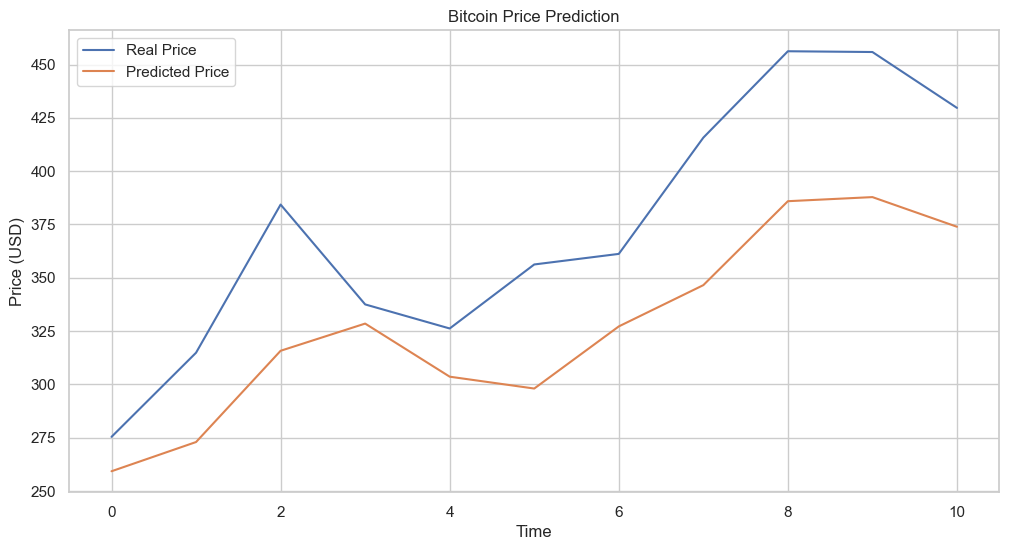

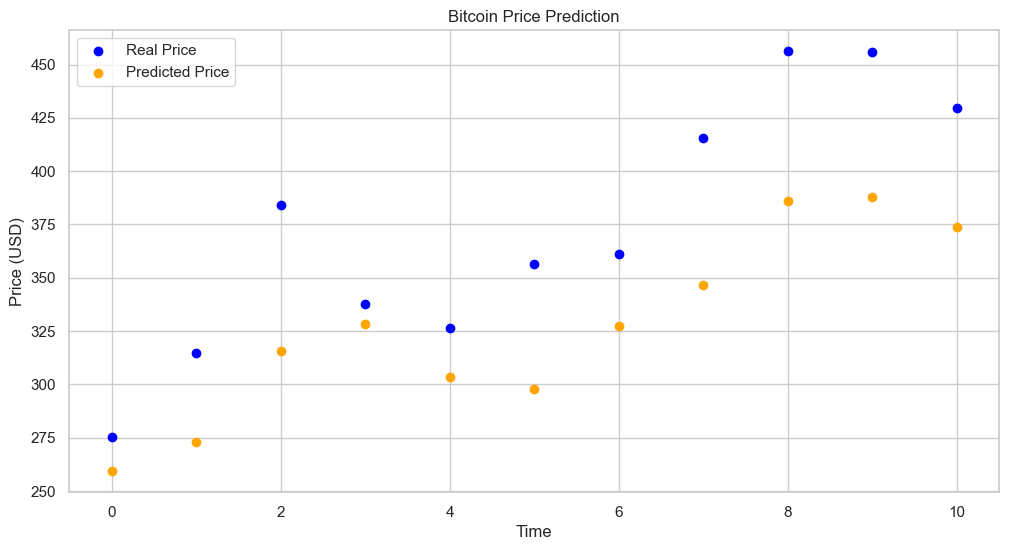

,Real Price,Predicted Price
0,275.41,259.28
1,314.88,272.99
2,384.34,315.78
3,337.52,328.53
4,326.23,303.63
5,356.26,298.07
6,361.21,327.20
7,415.73,346.56
8,456.24,385.92
9,455.88,387.84


Mean Squared Error (MSE): 2664.8708349692088
Root Mean Squared Error (RMSE): 51.62238695536278
Mean Absolute Error (MAE): 46.69323287297578
R² Score: 0.17937056017487696


In [8]:
# Construction du modèle LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model,"external.csv")

As we can see, the prediction is quite good. And we are able to reach an acceptable loss, and MSE. The R squared score is a little bit low: 
But by looking into the data, we can see that the prices are not varying that much. that's why the R2 score is not that good.
Let's do some tests with a more fluctuent price.     

For this purpose, we duplicated the external file and added some fake prices, for instance we make the price go from 400 more or less to around 2000. Let's see if this will impact the performance of the model. 

So we created two variants of the external file : 
- external_outliers_in_test.csv : contains outliers values only in the part that will be used for the test (so in the 20% of the file since we are splitting it into 80% - 20%)
- external_outliers_in_train.csv : contains outliers values in the 80% that is the train part and in the 20% that is the test part.

By using these files we'll be able to study and watch out the behaviour of our models while they're facing different scenarios. 

## External Extended

### External with outliers in test set.

We'll now test our LSTM model that was pretty good on the external.csv , on our new file external_outliers_in_test.csv and follow its performance

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.0010 - val_loss: 2.1720e-04
Epoch 2/100
1/1 [==============================] - 0s 145ms/step - loss: 4.5540e-04 - val_loss: 2.3405e-05
Epoch 3/100
1/1 [==============================] - 0s 62ms/step - loss: 1.4684e-04 - val_loss: 5.3212e-05
Epoch 4/100
1/1 [==============================] - 0s 59ms/step - loss: 7.5401e-05 - val_loss: 2.2231e-04
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 1.6782e-04 - val_loss: 3.6444e-04
Epoch 6/100
1/1 [==============================] - 0s 60ms/step - loss: 2.7086e-04 - val_loss: 3.8863e-04
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 2.8968e-04 - val_loss: 3.1864e-04
Epoch 8/100
1/1 [==============================] - 0s 71ms/step - loss: 2.3701e-04 - val_loss: 2.1153e-04
Epoch 9/100
1/1 [==============================] - 0s 57ms/step - loss: 1.6040e-04 - val_loss: 1.1290e-04
Epoch 10/100
1/1 [==============================] -

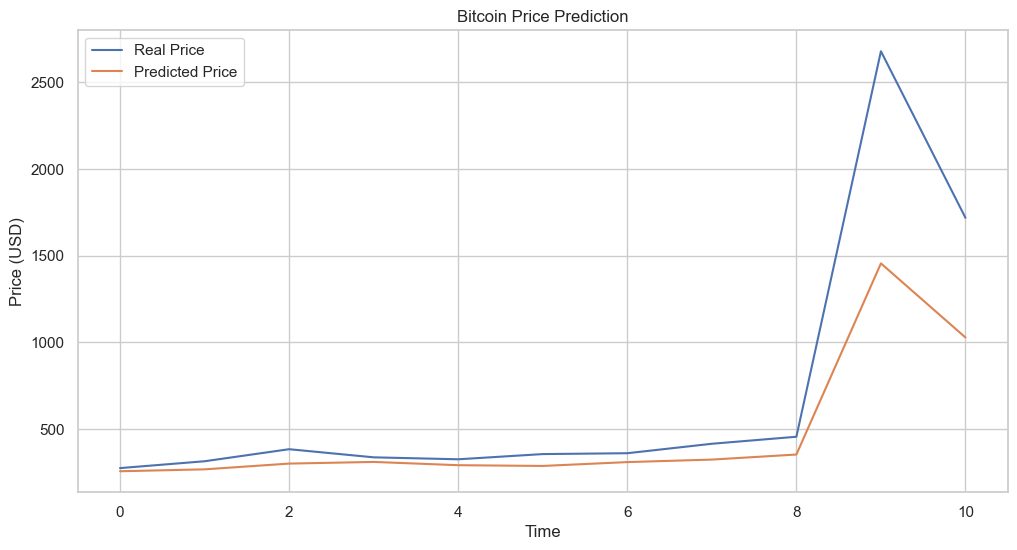

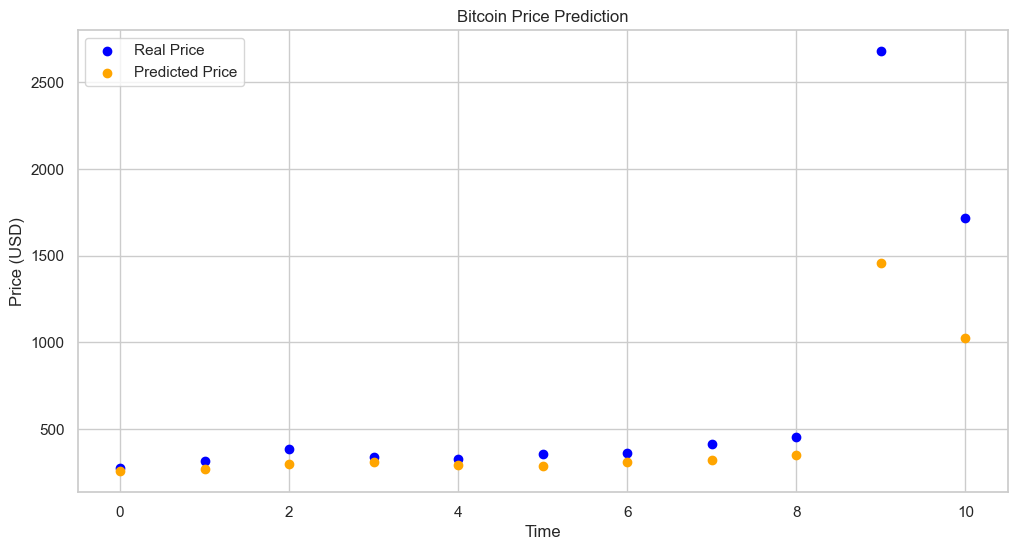

,Real Price,Predicted Price
0,275.41,257.24
1,314.88,268.22
2,384.34,301.42
3,337.52,311.00
4,326.23,292.16
5,356.26,287.85
6,361.21,310.01
7,415.73,324.49
8,456.24,353.68
9,2679.26,1455.89


Mean Squared Error (MSE): 182760.6333182927
Root Mean Squared Error (RMSE): 427.50512665732174
Mean Absolute Error (MAE): 221.39139728173734
R² Score: 0.6664527076959248


In [9]:
# Construction du modèle LSTM
model2 = Sequential()
model2.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model2.add(LSTM(50))
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model2,"external_outliers_in_test.csv")

The results obtained from testing the LSTM model on two different datasets – one with outliers and the other without – reveal interesting insights when looking at the Mean Absolute Error (MAE) and R² Score metrics.    
For the dataset containing outliers, we observe a higher MAE of 202.469, indicating that some predictions are significantly off from the actual values, a common occurrence in the presence of outliers. However, the R² Score is relatively high at 0.806, suggesting that the model is still able to explain the variance in the data. 
This high R² Score can occur even with a high MAE, especially in datasets with high variance due to outliers. 

On the other hand, in the dataset without outliers, the MAE is lower at 42.487, indicating that the predictions are generally closer to the actual values, as expected in outlier-free data. Yet, the R² Score drops to 0.311, implying that, despite more accurate predictions in terms of absolute error, the model explains a smaller proportion of the data's variance. This lower R² Score could be attributed to the overall lower variability in the dataset without outliers. 

These results highlight that MAE and R² Score measure different aspects of model performance. A higher MAE in the presence of outliers doesn't necessarily imply poor model performance in terms of variance explained, as indicated by the R² Score. It's crucial to consider both metrics together for a comprehensive understanding of the model's performance.

### External with outliers in train 

Epoch 1/100
2/2 [==============================] - 4s 860ms/step - loss: 0.0565 - val_loss: 0.0875
Epoch 2/100
2/2 [==============================] - 0s 38ms/step - loss: 0.0487 - val_loss: 0.0764
Epoch 3/100
2/2 [==============================] - 0s 37ms/step - loss: 0.0428 - val_loss: 0.0667
Epoch 4/100
2/2 [==============================] - 0s 36ms/step - loss: 0.0376 - val_loss: 0.0579
Epoch 5/100
2/2 [==============================] - 0s 78ms/step - loss: 0.0328 - val_loss: 0.0496
Epoch 6/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0281 - val_loss: 0.0416
Epoch 7/100
2/2 [==============================] - 0s 35ms/step - loss: 0.0235 - val_loss: 0.0336
Epoch 8/100
2/2 [==============================] - 0s 49ms/step - loss: 0.0189 - val_loss: 0.0258
Epoch 9/100
2/2 [==============================] - 0s 39ms/step - loss: 0.0144 - val_loss: 0.0182
Epoch 10/100
2/2 [==============================] - 0s 44ms/step - loss: 0.0101 - val_loss: 0.0110
Epoch 11/100
2/2 [

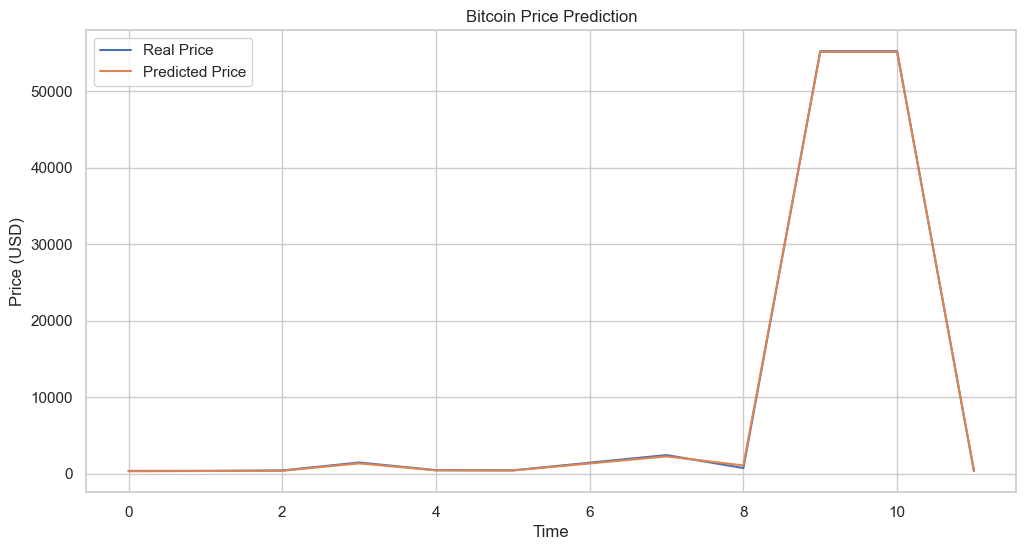

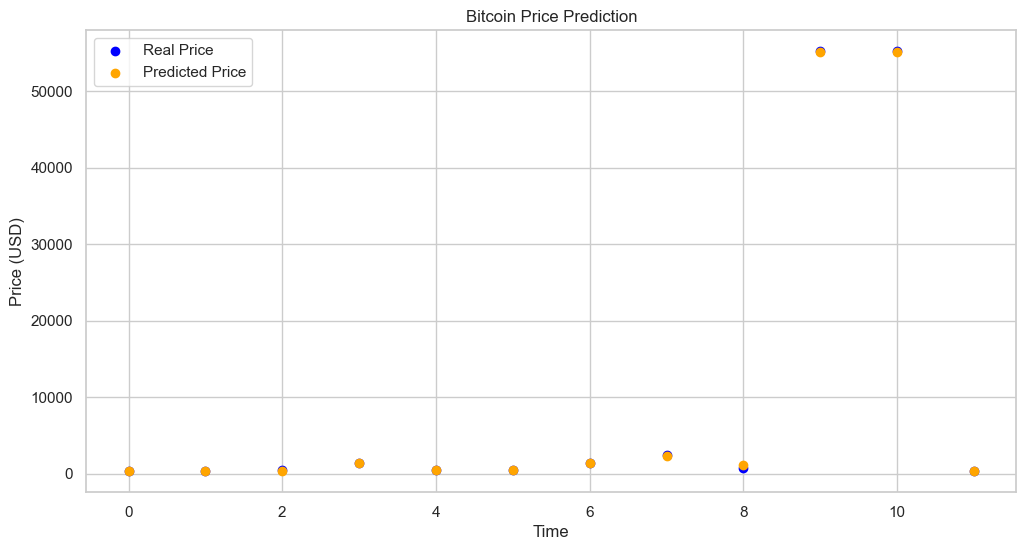

,Real Price,Predicted Price
0,356.26,312.46
1,361.21,349.76
2,415.73,372.15
3,1456.24,1342.25
4,455.88,428.51
5,429.68,410.62
6,1429.68,1328.84
7,2429.68,2252.97
8,729.68,1075.54
9,55259.68,55174.13


Mean Squared Error (MSE): 16150.826012756383
Root Mean Squared Error (RMSE): 127.08590013355683
Mean Absolute Error (MAE): 88.6537231079631
R² Score: 0.9999607706868312


In [10]:
# Construction du modèle LSTM
model3 = Sequential()
model3.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model3.add(LSTM(50))
model3.add(Dense(1))
model3.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model3,"external_outliers_in_train.csv")

Of course here, we have quite better results when we include the outliers in the train AND in the test part together. But let's see if we can make our model very performant on outliers even without training it on these outliers.

## Problem : 
  
We are encountering a common challenge in time series prediction, particularly when there are sudden changes or anomalies in the data. The issue arises when our LSTM model, trained on the 2015 Bitcoin price data, struggles to accurately predict prices during a test week where prices are significantly higher than those seen during the training period. Specifically, our model has been trained and tested on data where each sequence consists of 6 days used to predict the price on the 7th day.

In the 2015 dataset, the model performs well because the test set (20% of the data) closely resembles the training set (80% of the data). However, when we introduce a new week into the test set with substantially higher Bitcoin prices than previously seen, the model's prediction for the 7th day of this week is less accurate, so the performance lows.    

This situation illustrates the difficulty of time series prediction models, like LSTM, in handling scenarios where test data exhibit trends or values that are markedly different from the training data. Our challenge is to improve the model's ability to handle such cases and enhance its predictive accuracy, even when confronted with data that significantly deviates from the historical range it was trained on.

To do that we thought about some possible solutions

- Improve the LSTM model by adding layers, complexify it ? 
- Features engineering to feed the LSTM or other models. 
- Find another model that will be able to capture these outliers and to predict well.
- Train our model on task1 data. 

We have to note that until now we were using only the external csv file. By_actor.csv and global.csv can be very useful to handle the challenge that we are facing.

## First try: Complexify a little bit our LSTM model
Let's see if complexifying the model will help it to handle these outliers and to predict their values.

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.0673 - val_loss: 0.0263
Epoch 2/100
1/1 [==============================] - 0s 91ms/step - loss: 0.0448 - val_loss: 0.0112
Epoch 3/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0240 - val_loss: 0.0013
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 5/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0059 - val_loss: 0.0206
Epoch 6/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0167 - val_loss: 0.0165
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0130 - val_loss: 0.0075
Epoch 8/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0065 - val_loss: 0.0020
Epoch 9/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0037 - val_loss: 6.3053e-04
Epoch 10/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0043 - val_loss: 0.0011
Epoch 11/100
1/1 

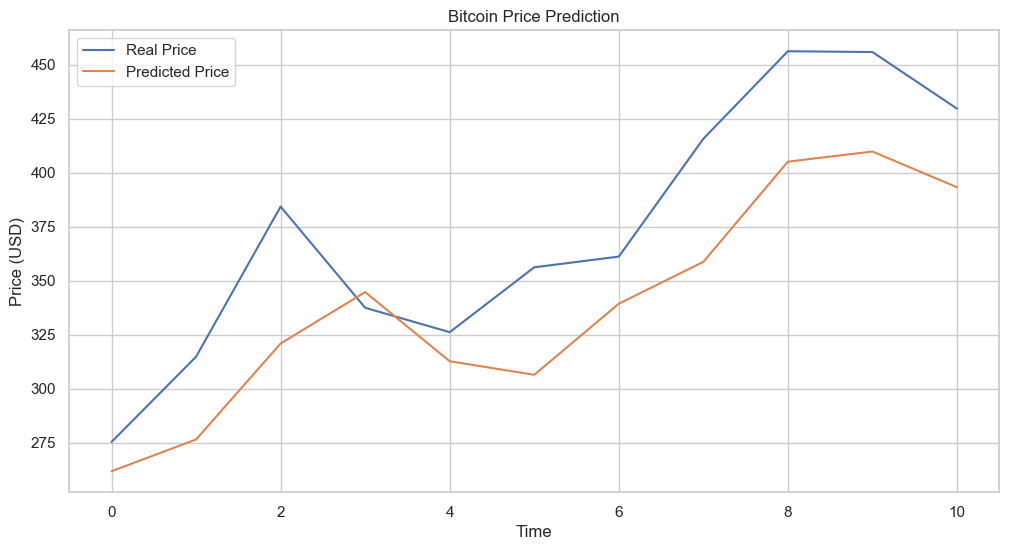

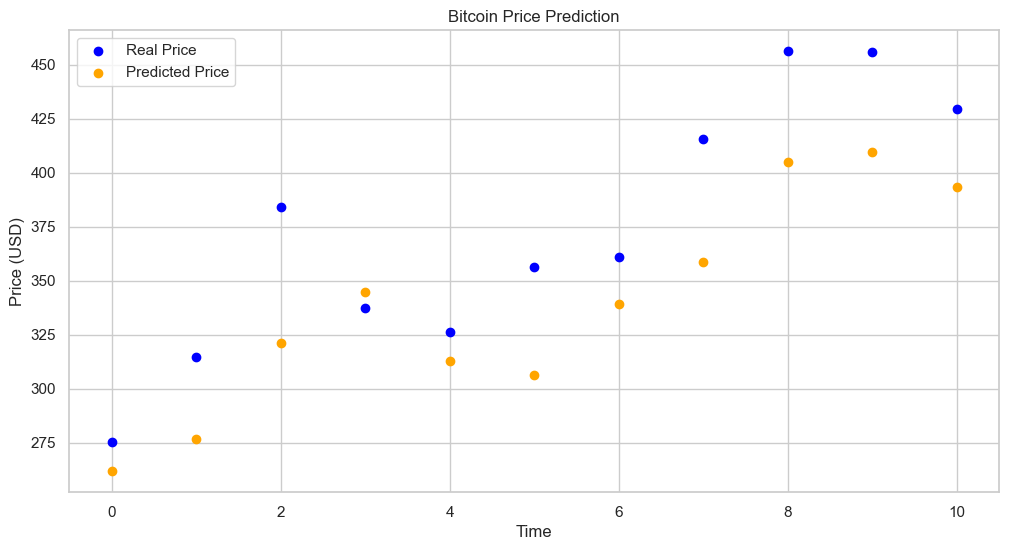

,Real Price,Predicted Price
0,275.41,261.87
1,314.88,276.58
2,384.34,321.01
3,337.52,344.78
4,326.23,312.78
5,356.26,306.51
6,361.21,339.40
7,415.73,358.78
8,456.24,405.15
9,455.88,409.84


Mean Squared Error (MSE): 1649.2437794767795
Root Mean Squared Error (RMSE): 40.610882525214585
Mean Absolute Error (MAE): 36.17249595365194
R² Score: 0.4921262294865648
Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 9.2944e-04 - val_loss: 1.9474e-04
Epoch 2/100
1/1 [==============================] - 0s 72ms/step - loss: 1.4854e-04 - val_loss: 6.8060e-04
Epoch 3/100
1/1 [==============================] - 0s 54ms/step - loss: 5.1143e-04 - val_loss: 3.3551e-04
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 2.4349e-04 - val_loss: 4.3801e-05
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 7.2691e-05 - val_loss: 2.5465e-05
Epoch 6/100
1/1 [==============================] - 0s 46ms/step - loss: 1.4694e-04 - val_loss: 7.1428e-05
Epoch 7/100
1/1 [==============================] - 0s 50ms/step - loss: 2.2339e-04 - val_loss: 5.3993e-05
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 2.0072e-04 - val_l

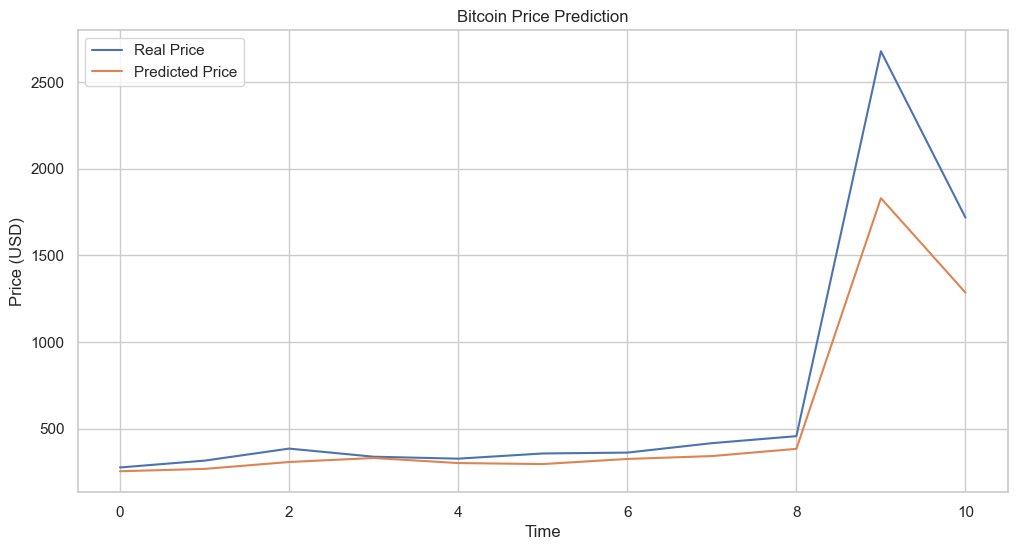

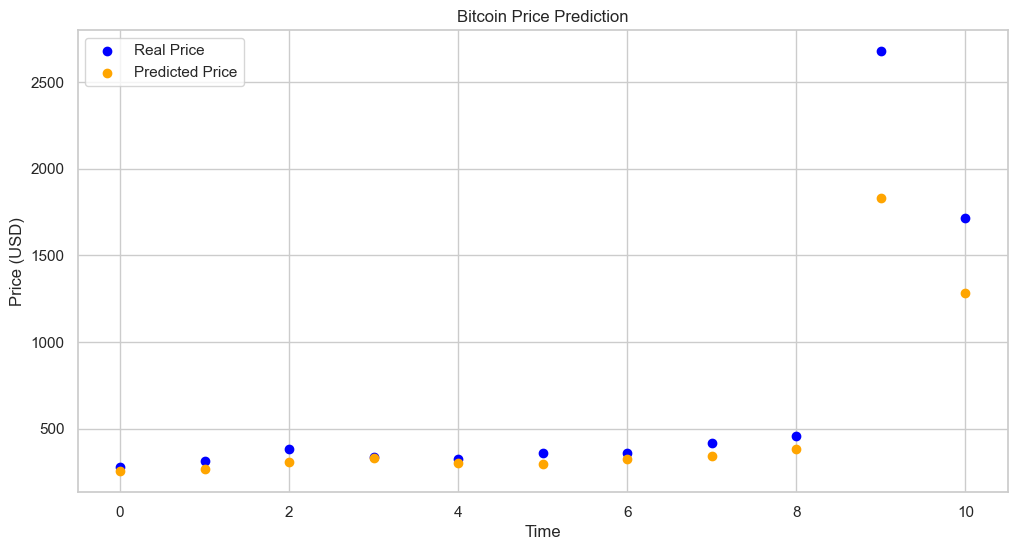

,Real Price,Predicted Price
0,275.41,253.56
1,314.88,267.13
2,384.34,306.99
3,337.52,330.10
4,326.23,300.87
5,356.26,295.03
6,361.21,324.53
7,415.73,341.19
8,456.24,382.92
9,2679.26,1830.89


Mean Squared Error (MSE): 84826.06026834704
Root Mean Squared Error (RMSE): 291.24913779846116
Mean Absolute Error (MAE): 155.2131468822345
R² Score: 0.8451881994189964


In [11]:
model4 = Sequential()
model4.add(LSTM(128, return_sequences=True, input_shape=(6, 1)))  # Couche LSTM
model4.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model4.add(GRU(128, return_sequences=True))  # Couche GRU
model4.add(Dropout(0.2))  # Autre couche Dropout
model4.add(LSTM(128, return_sequences=True))  # Autre couche LSTM
model4.add(Dropout(0.2))  # Autre couche Dropout
model4.add(GRU(128))  # Autre couche GRU
model4.add(Dense(1))  # Couche de sortie
model4.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model4,"external.csv")

model5 = Sequential()
model5.add(LSTM(128, return_sequences=True, input_shape=(6, 1)))  # Couche LSTM
model5.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model5.add(GRU(128, return_sequences=True))  # Couche GRU
model5.add(Dropout(0.2))  # Autre couche Dropout
model5.add(LSTM(128, return_sequences=True))  # Autre couche LSTM
model5.add(Dropout(0.2))  # Autre couche Dropout
model5.add(GRU(128))  # Autre couche GRU
model5.add(Dense(1))  # Couche de sortie
model5.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model5,"external_outliers_in_test.csv")

## 2nd try: Let's try GRU.

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.0703 - val_loss: 0.0144
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0268 - val_loss: 6.1597e-04
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0038 - val_loss: 0.0091
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0093 - val_loss: 0.0162
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0175 - val_loss: 0.0102
Epoch 6/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0109 - val_loss: 0.0031
Epoch 7/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0033 - val_loss: 4.1225e-04
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 9/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 10/100
1/1 [==============================] - 0s 46ms/step - loss: 0.0061 - val_loss: 0.0030
Epoch 11/100


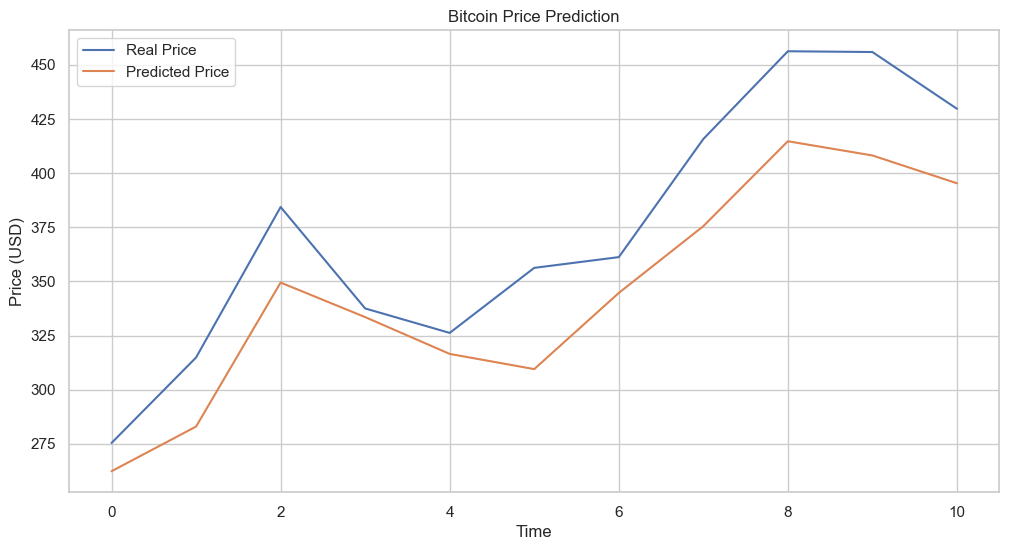

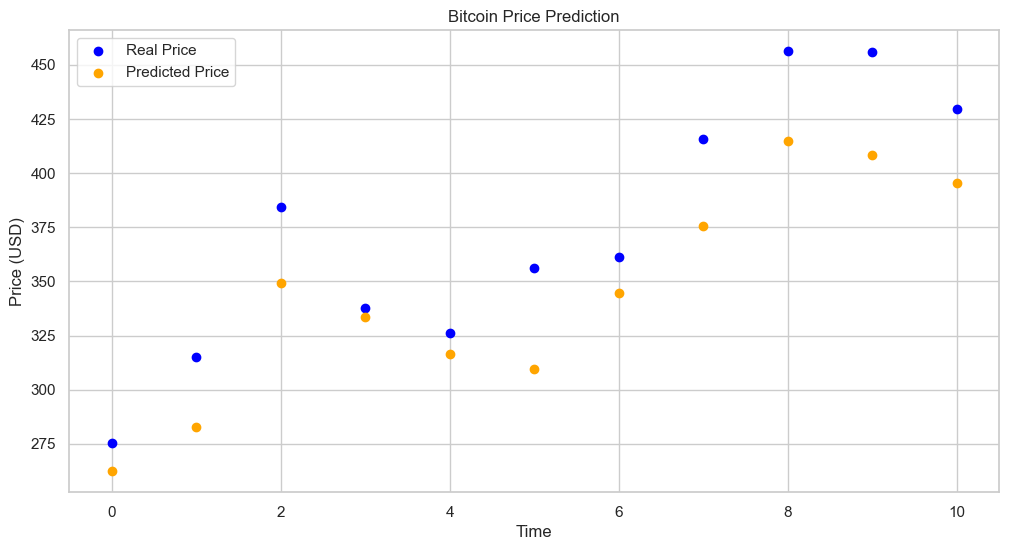

,Real Price,Predicted Price
0,275.41,262.37
1,314.88,283.00
2,384.34,349.48
3,337.52,333.52
4,326.23,316.54
5,356.26,309.52
6,361.21,344.68
7,415.73,375.50
8,456.24,414.70
9,455.88,408.13


Mean Squared Error (MSE): 1070.4170683195575
Root Mean Squared Error (RMSE): 32.717228921770825
Mean Absolute Error (MAE): 29.149451245667535
R² Score: 0.6703721067349673


In [12]:
model6 = Sequential()
model6.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))  # Première couche GRU
model6.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model6.add(GRU(128, return_sequences=True))  # Deuxième couche GRU
model6.add(Dropout(0.2))  # Autre couche Dropout
model6.add(GRU(128))  # Troisième couche GRU
model6.add(Dense(1))  # Couche de sortie
model6.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model6,"external.csv")

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 9.3861e-04 - val_loss: 5.4908e-04
Epoch 2/100
1/1 [==============================] - 0s 109ms/step - loss: 4.4154e-04 - val_loss: 5.9456e-04
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 4.7715e-04 - val_loss: 9.8725e-05
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 8.4703e-05 - val_loss: 2.5511e-05
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 1.2526e-04 - val_loss: 1.1148e-04
Epoch 6/100
1/1 [==============================] - 0s 44ms/step - loss: 2.6706e-04 - val_loss: 8.2892e-05
Epoch 7/100
1/1 [==============================] - 0s 45ms/step - loss: 2.1997e-04 - val_loss: 1.6550e-05
Epoch 8/100
1/1 [==============================] - 0s 45ms/step - loss: 1.0792e-04 - val_loss: 2.9296e-05
Epoch 9/100
1/1 [==============================] - 0s 44ms/step - loss: 5.9979e-05 - val_loss: 1.2389e-04
Epoch 10/100
1/1 [=============================

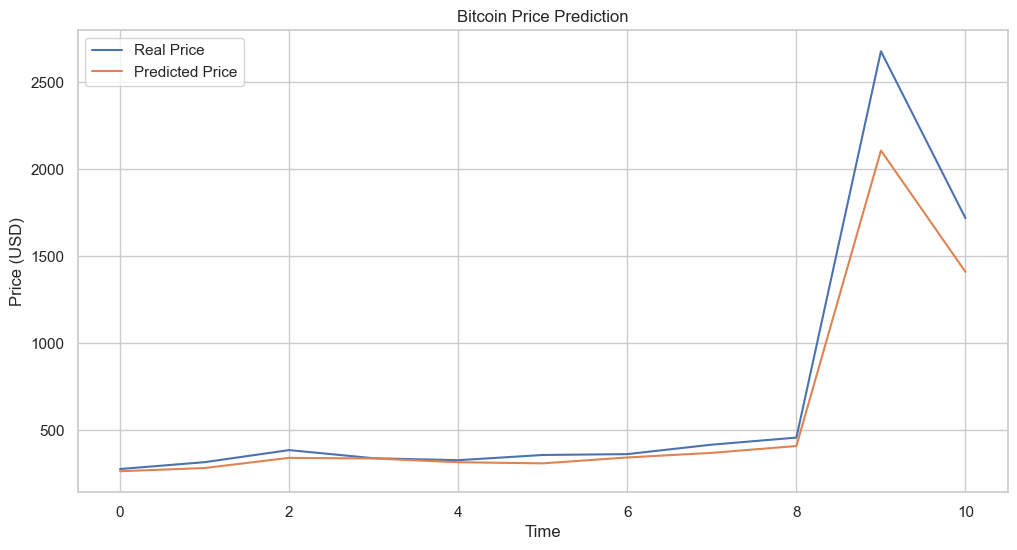

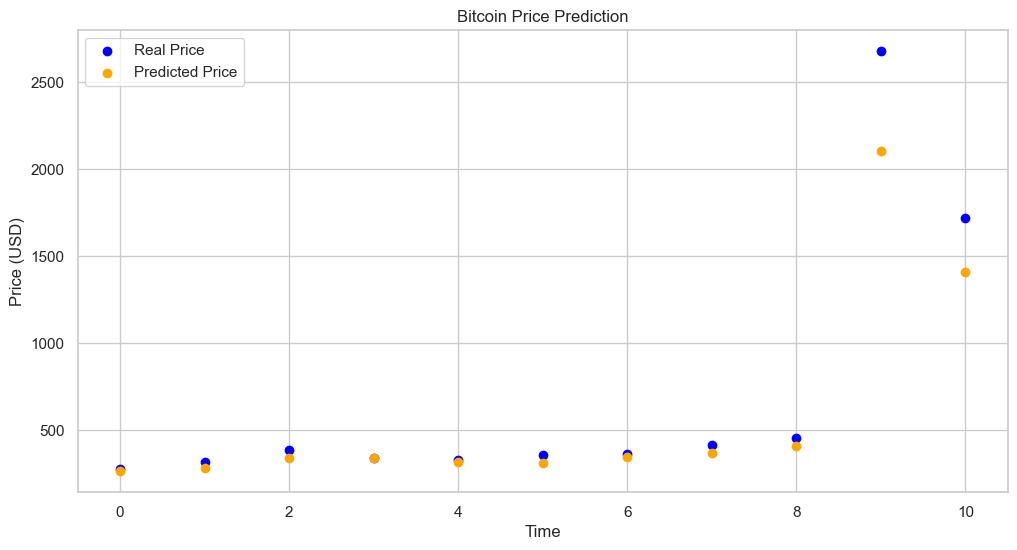

,Real Price,Predicted Price
0,275.41,262.63
1,314.88,281.19
2,384.34,339.66
3,337.52,336.03
4,326.23,314.49
5,356.26,308.04
6,361.21,341.94
7,415.73,368.47
8,456.24,407.87
9,2679.26,2108.14


Mean Squared Error (MSE): 39296.78941613827
Root Mean Squared Error (RMSE): 198.23417822398406
Mean Absolute Error (MAE): 104.31493687690781
R² Score: 0.9282813948058013


In [13]:
model7 = Sequential()
model7.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))  # Première couche GRU
model7.add(Dropout(0.2))  # Couche Dropout pour la régularisation
model7.add(GRU(128, return_sequences=True))  # Deuxième couche GRU
model7.add(Dropout(0.2))  # Autre couche Dropout
model7.add(GRU(128))  # Troisième couche GRU
model7.add(Dense(1))  # Couche de sortie
model7.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model7,"external_outliers_in_test.csv")

## Let's try to add some attention

In [14]:
from keras.layers import Layer
import keras.backend as K

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', 
                                 shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        self.b = self.add_weight(name='attention_bias',
                                 shape=(input_shape[1], 1),
                                 initializer='zeros',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0675 - val_loss: 0.0325
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.0527 - val_loss: 0.0232
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0400 - val_loss: 0.0154
Epoch 4/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0290 - val_loss: 0.0093
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0193 - val_loss: 0.0047
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0126 - val_loss: 0.0018
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0070 - val_loss: 6.0109e-04
Epoch 8/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 9/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0033 - val_loss: 0.0055
Epoch 11/100
1/1 

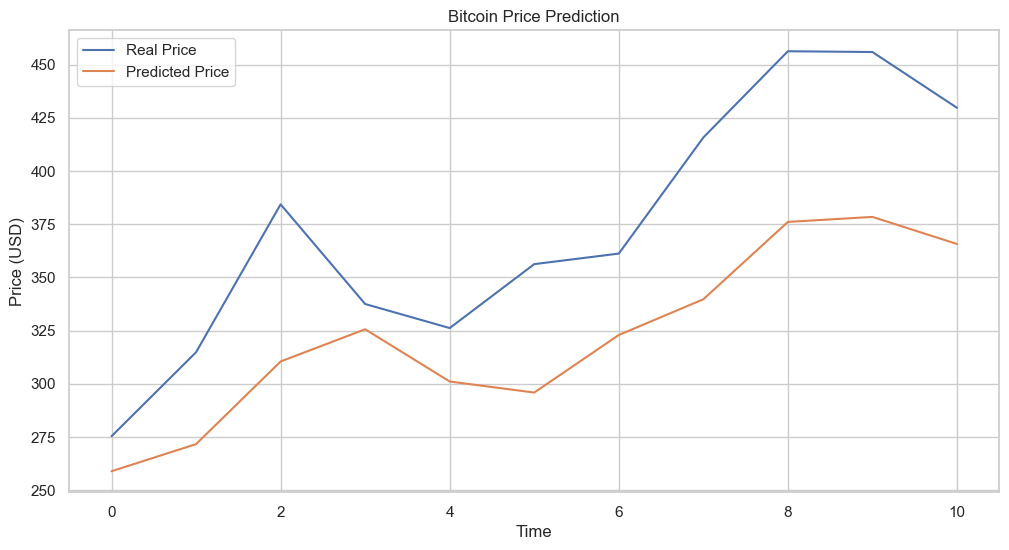

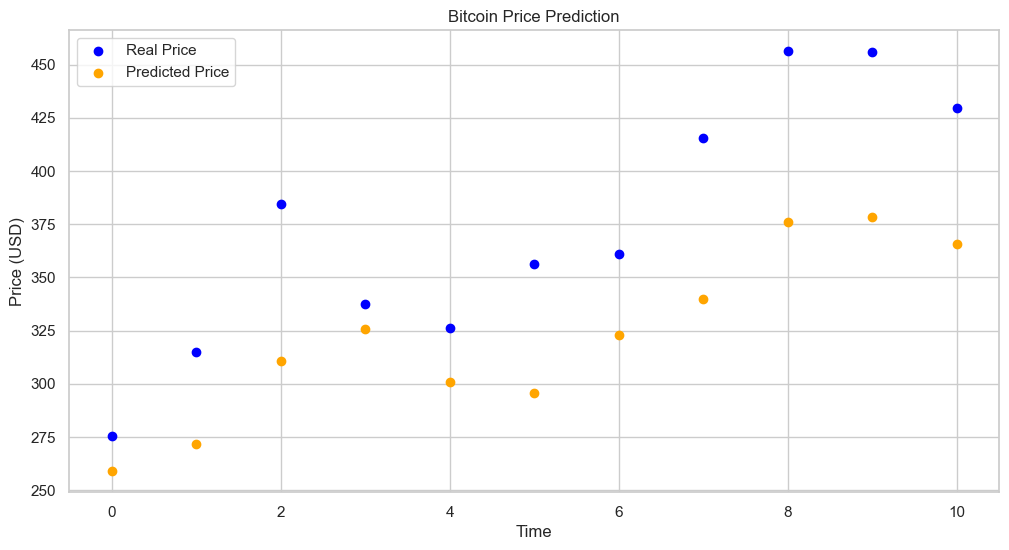

,Real Price,Predicted Price
0,275.41,258.98
1,314.88,271.72
2,384.34,310.53
3,337.52,325.66
4,326.23,301.13
5,356.26,295.93
6,361.21,322.96
7,415.73,339.75
8,456.24,376.08
9,455.88,378.44


Mean Squared Error (MSE): 3249.0236042144056
Root Mean Squared Error (RMSE): 57.00020705413627
Mean Absolute Error (MAE): 51.49816451360078
R² Score: -0.0005154416183466015


In [15]:
model8 = Sequential()
model8.add(GRU(128, return_sequences=True, input_shape=(seq_length, 1)))
model8.add(Dropout(0.2))
model8.add(AttentionLayer())  # Ajout de la couche d'attention
model8.add(Dense(1))
model8.compile(optimizer='adam', loss='mean_squared_error')
train_and_test_model(model8,"external.csv")

## Features Engineering

During the Exploratory Analysis, we found out some interesting correlations, that can be useful for our prediction.   
First of all, let's try to include the HashRate of the external file as a feature.

In [16]:
def create_sequences_features(data, seq_length):
    xs, ys = [], []
    total_weeks = len(data) // (seq_length + 1)  # Nombre total de semaines

    for week in range(total_weeks):
        start_index = week * (seq_length + 1)
        
        x = data[start_index:(start_index + seq_length), :]
        y = data[start_index + seq_length, 0]  # Prend uniquement la valeur PriceUSD pour le jour 6
        
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [17]:
def read_data(file_name, features=['PriceUSD']):
    data = pd.read_csv(file_name)    
    return data[features].values

def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(data), scaler

def inverse_transform_predictions(predicted, y_test, scaler, nb_features=1):
    predicted_adjusted = np.zeros((predicted.shape[0], nb_features))
    
    predicted_adjusted[:, 0] = predicted.ravel()
    predicted_prices = scaler.inverse_transform(predicted_adjusted)[:, 0]

    y_test_adjusted = y_test[:predicted.shape[0]].ravel()
    real_prices_adjusted = np.zeros((predicted.shape[0], nb_features))
    real_prices_adjusted[:, 0] = y_test_adjusted
    real_prices = scaler.inverse_transform(real_prices_adjusted)[:, 0]

    return predicted_prices, real_prices

def train_test_split(X, y, threshold=0.8):
    train_size = int(len(X) * threshold)
    return X[:train_size], X[train_size:], y[:train_size], y[train_size:]

def train_and_test_model(model, trainX, testX, trainY):
    model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.2, shuffle=False)
    return model.predict(testX)
   
def build_model(intput_shape):
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape=intput_shape))
    model.add(LSTM(128))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

## Add HashRate as a feature 

In [18]:
data = read_data('../data/timeseries/2015/external.csv', features=['PriceUSD', 'HashRate'])
data_scaled, scaler = scale_data(data)

seq_length = 6
X, y = create_sequences_features(data_scaled, seq_length)
trainX, testX, trainY, testY = train_test_split(X, y)

model = build_model(trainX.shape[1:])

In [19]:
predictions = train_and_test_model(model, trainX, testX, trainY)

Epoch 1/100


1/1 [==============================] - 4s 4s/step - loss: 0.0768 - val_loss: 0.0341
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0540 - val_loss: 0.0203
Epoch 3/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0356 - val_loss: 0.0096
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0206 - val_loss: 0.0026
Epoch 5/100
1/1 [==============================] - 0s 73ms/step - loss: 0.0092 - val_loss: 5.2586e-04
Epoch 6/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0034 - val_loss: 0.0139
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0091 - val_loss: 0.0183
Epoch 9/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0125 - val_loss: 0.0165
Epoch 10/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 11/100
1/1 [===========

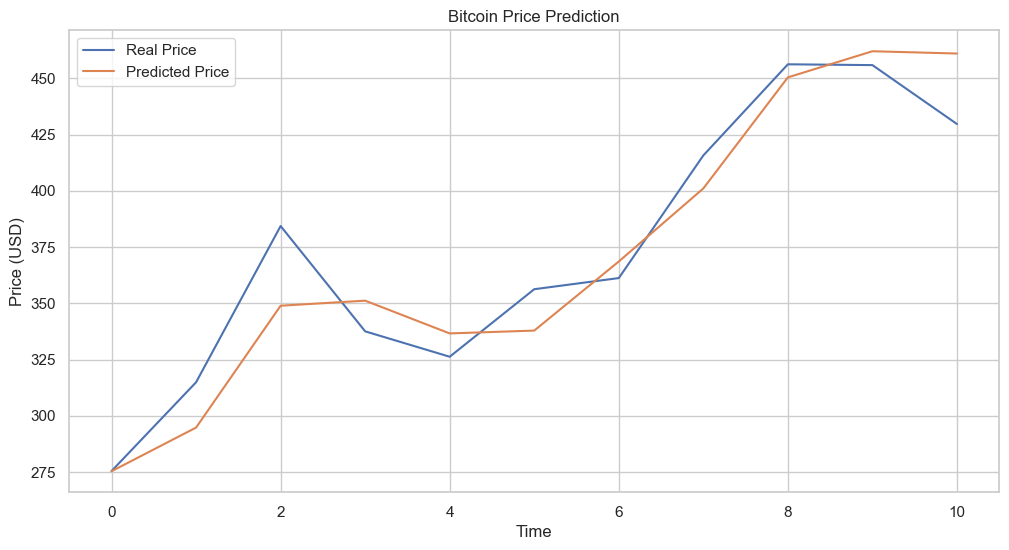

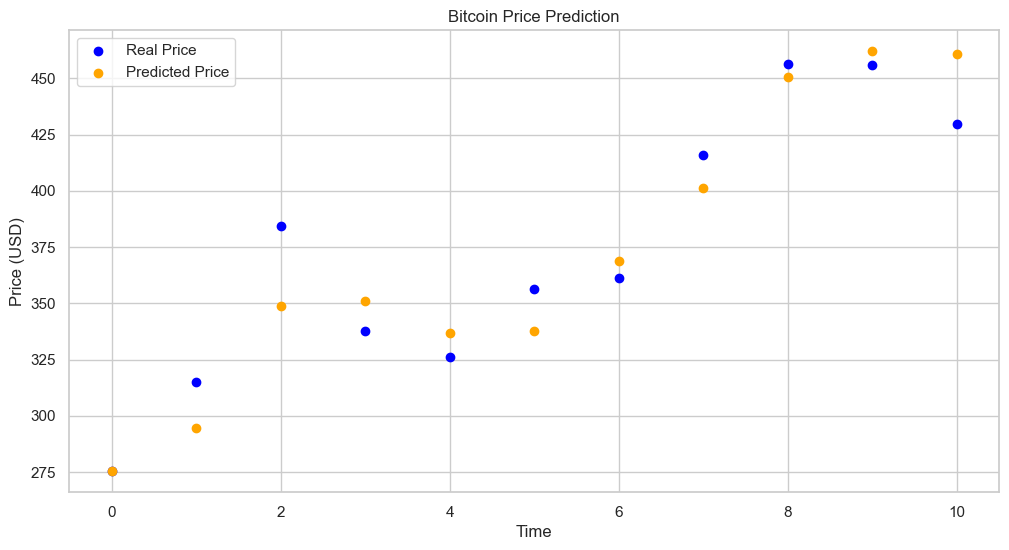

,Real Price,Predicted Price
0,275.41,275.33
1,314.88,294.74
2,384.34,348.91
3,337.52,351.16
4,326.23,336.60
5,356.26,337.86
6,361.21,368.58
7,415.73,401.05
8,456.24,450.43
9,455.88,462.04


Mean Squared Error (MSE): 328.82907370752815
Root Mean Squared Error (RMSE): 18.1336447993096
Mean Absolute Error (MAE): 14.857229914963414
R² Score: 0.8987392503179461


(328.82907370752815, 18.1336447993096, 14.857229914963414, 0.8987392503179461)

In [20]:
predicted_prices, real_prices = inverse_transform_predictions(predictions, testY, scaler, nb_features=trainX.shape[2])
show_results(predicted_prices, real_prices)

Including the HashRate as a feature of our model is granting us pretty good results when we look at the R2 Score and the Mean Absolute Error. Let's try our model on external_outliers_in_test to confirm that.

In [21]:
data = read_data('../data/timeseries/2015/external_outliers_in_test.csv', features=['PriceUSD', 'HashRate'])
data_scaled, scaler = scale_data(data)

seq_length = 6
X, y = create_sequences_features(data_scaled, seq_length)
trainX, testX, trainY, testY = train_test_split(X, y)

model = build_model(trainX.shape[1:])

In [22]:
predictions = train_and_test_model(model, trainX, testX, trainY)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0010 - val_loss: 3.7593e-05
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 1.7801e-04 - val_loss: 1.7609e-04
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 1.2368e-04 - val_loss: 5.0981e-04
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 3.5537e-04 - val_loss: 4.8407e-04
Epoch 5/100
1/1 [==============================] - 0s 42ms/step - loss: 3.3551e-04 - val_loss: 2.7224e-04
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 1.8190e-04 - val_loss: 9.2800e-05
Epoch 7/100
1/1 [==============================] - 0s 39ms/step - loss: 7.4695e-05 - val_loss: 1.5400e-05
Epoch 8/100
1/1 [==============================] - 0s 43ms/step - loss: 6.2669e-05 - val_loss: 1.3620e-05
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 1.0903e-04 - val_loss: 3.4628e-05
Epoch 10/100
1/1 [==============================] - 

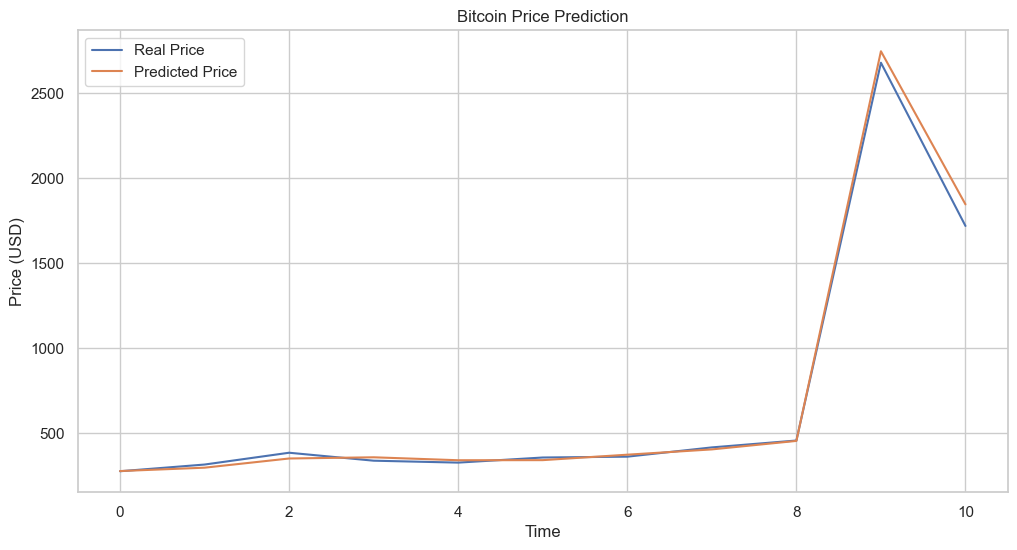

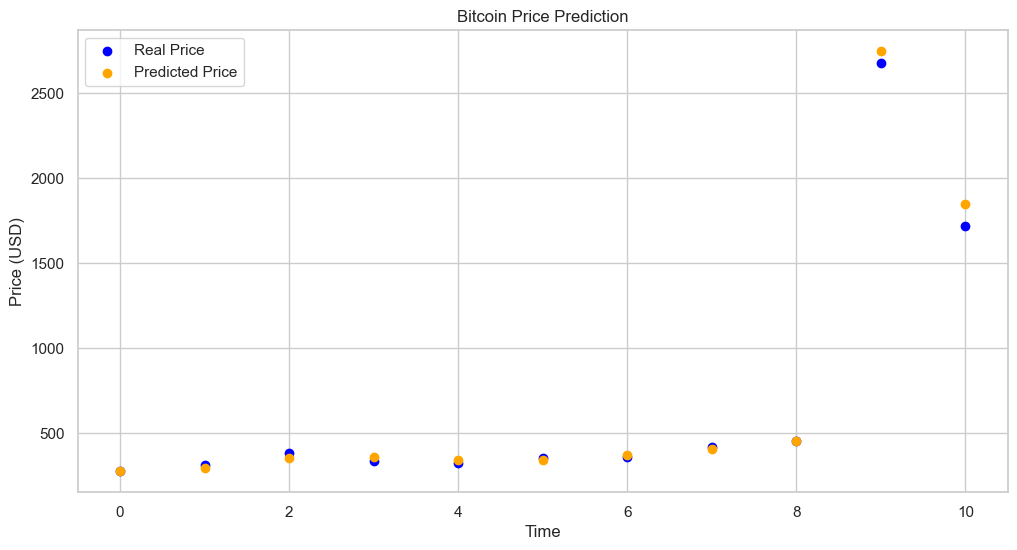

,Real Price,Predicted Price
0,275.41,276.55
1,314.88,296.39
2,384.34,350.49
3,337.52,357.51
4,326.23,340.18
5,356.26,340.77
6,361.21,372.84
7,415.73,403.96
8,456.24,453.96
9,2679.26,2746.72


Mean Squared Error (MSE): 2116.3382319713364
Root Mean Squared Error (RMSE): 46.00367628756789
Mean Absolute Error (MAE): 29.366821378771693
R² Score: 0.996137576927498


(2116.3382319713364, 46.00367628756789, 29.366821378771693, 0.996137576927498)

In [23]:
predicted_prices, real_prices = inverse_transform_predictions(predictions, testY, scaler, nb_features=trainX.shape[2])
show_results(predicted_prices, real_prices)

Even on our fake dataset containing outliers, the model is able to predict with a high accuracy. Now that we are sure that our model has a good R2 score, let's try to improve as far as possible the MAE, to get as close as possible to the actual price. 

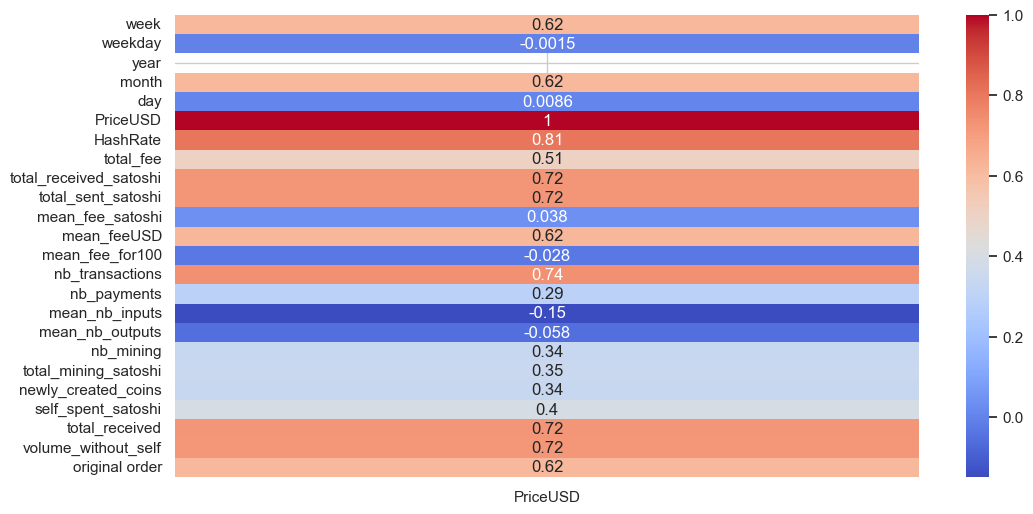

In [24]:
df1 = pd.read_csv('../data/timeseries/2015/external.csv')
df2 = pd.read_csv('../data/timeseries/2015/global.csv')

merged = pd.merge(df1, df2, on=['week', 'weekday','month','year','day'])
if 'xxxx' in merged.columns:
    merged.drop(columns=['xxxx'], inplace=True)

merged.to_csv('../data/timeseries/2015/merged.csv', index=False)


corr = merged.corr()
corr_price = corr[['PriceUSD']]
# plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_price, annot=True, cmap='coolwarm')
plt.show()

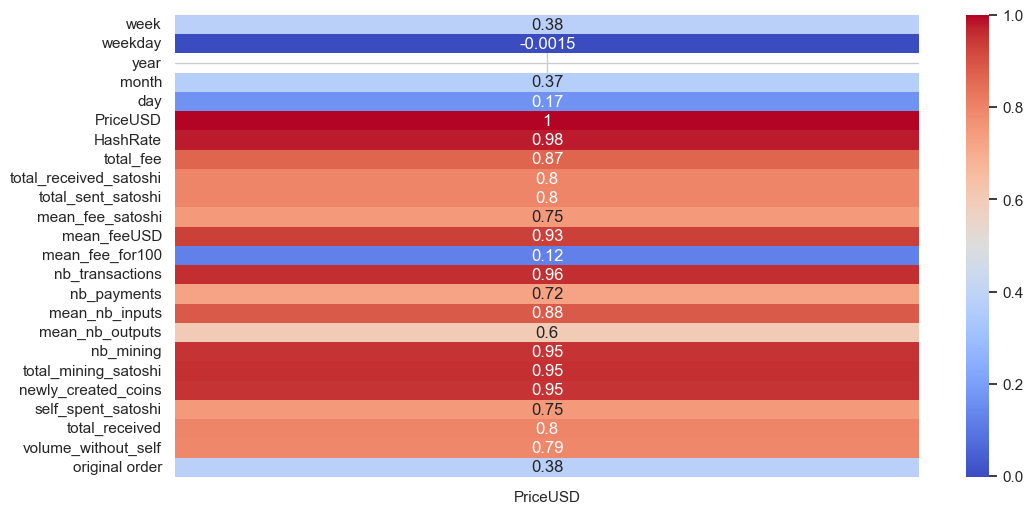

In [26]:
df1 = pd.read_csv('../../data/timeseries/2015/external_outliers_in_test_last_week.csv')
df2 = pd.read_csv('../../data/timeseries/2015/global_outliers_in_test_last_week.csv')

merged_outliers = pd.merge(df1, df2, on=['week', 'weekday','month','year','day'])
if 'xxxx' in merged_outliers.columns:
    merged_outliers.drop(columns=['xxxx'], inplace=True)

merged_outliers.to_csv('../data/timeseries/2015/merged_outliers.csv', index=False)


corr = merged_outliers.corr()
corr_price = corr[['PriceUSD']]
# plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr_price, annot=True, cmap='coolwarm')
plt.show()

Interesting features : total_received_satoshi, nb_transactions, week, month, volume_without_self,total_sent_satoshi

Testing with: ['HashRate'] 

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0745 - val_loss: 0.0312
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0556 - val_loss: 0.0194
Epoch 3/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0393 - val_loss: 0.0099
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0252 - val_loss: 0.0032
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0135 - val_loss: 4.1602e-04
Epoch 6/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0052 - val_loss: 0.0033
Epoch 7/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0021 - val_loss: 0.0125
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 0.0054 - val_loss: 0.0214
Epoch 9/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0108 - val_loss: 0.0232
Epoch 10/100
1/1 [==============================] - 0s 51ms/step - loss: 0.0120 - val_l

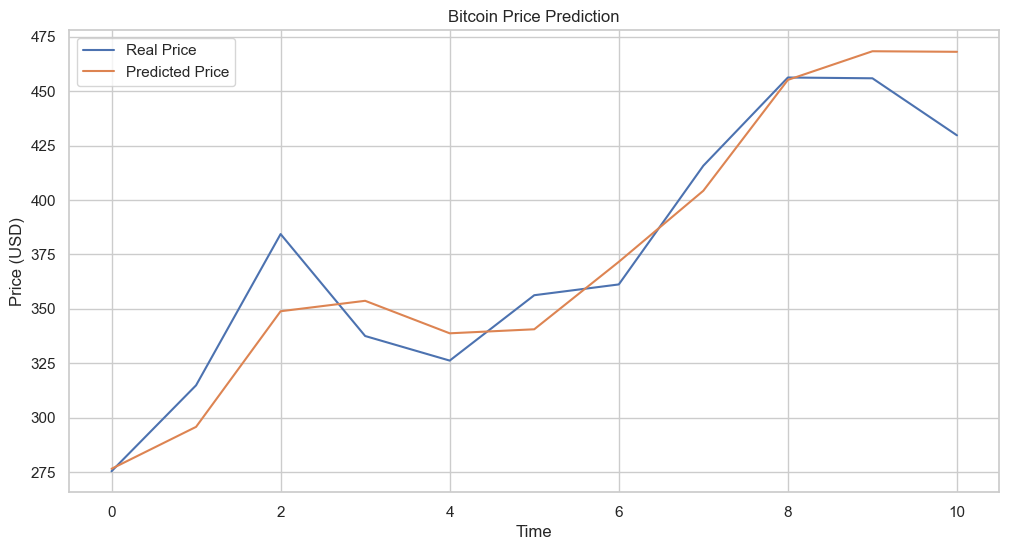

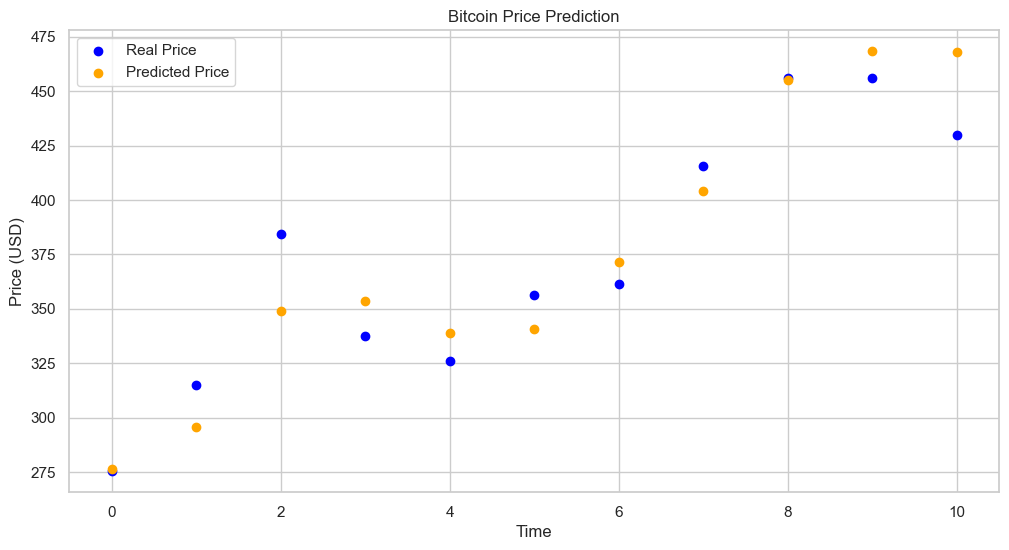

,Real Price,Predicted Price
0,275.41,276.54
1,314.88,295.80
2,384.34,348.90
3,337.52,353.69
4,326.23,338.76
5,356.26,340.61
6,361.21,371.59
7,415.73,404.24
8,456.24,455.15
9,455.88,468.30


Mean Squared Error (MSE): 377.4197684857523
Root Mean Squared Error (RMSE): 19.427294420112965
Mean Absolute Error (MAE): 15.794240255350054
R² Score: 0.8837760655686829
Testing with: ['total_received_satoshi'] 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0668 - val_loss: 0.0301
Epoch 2/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0489 - val_loss: 0.0190
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0332 - val_loss: 0.0097
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0197 - val_loss: 0.0031
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0091 - val_loss: 5.1796e-04
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 7/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0034 - val_loss: 0.0104
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0091 - val_loss: 0.0137
E

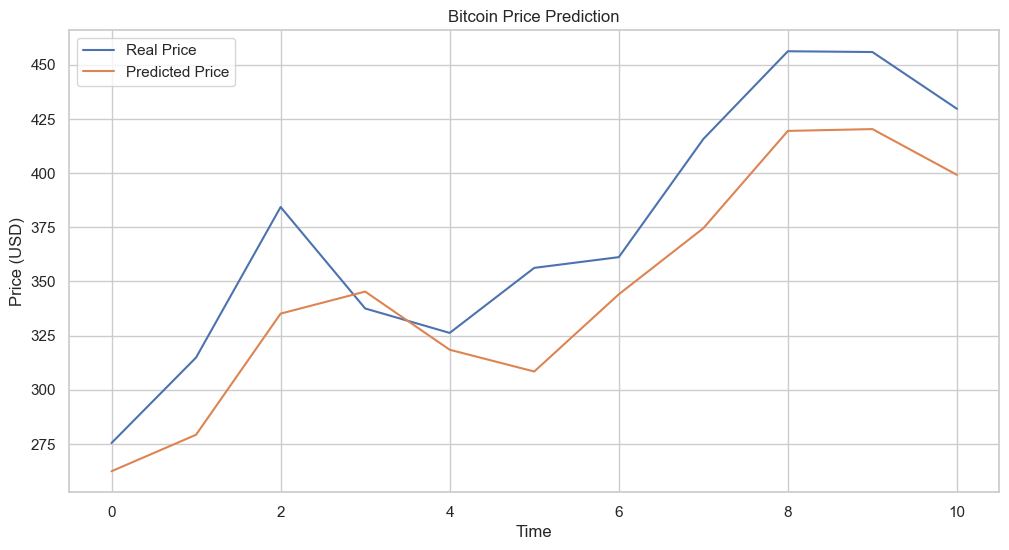

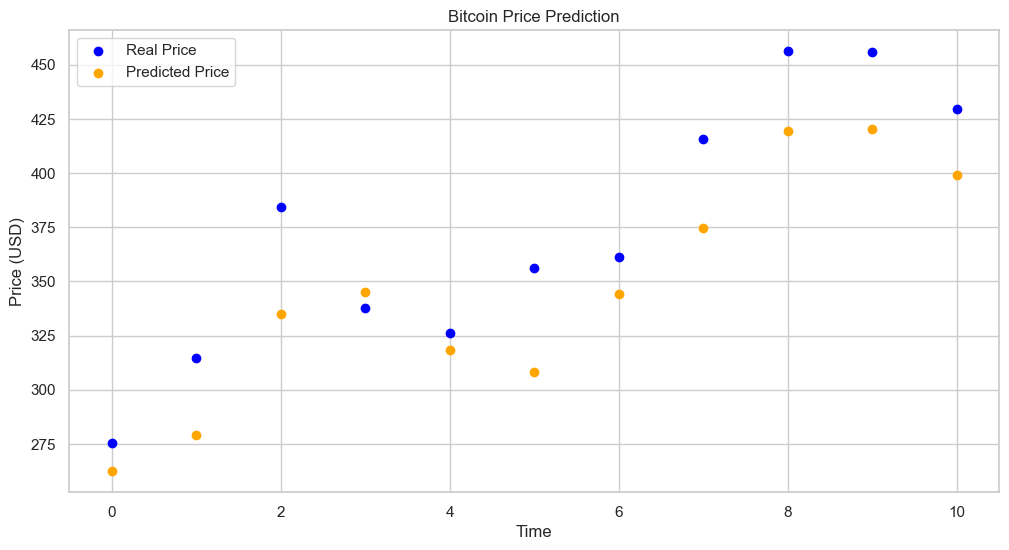

,Real Price,Predicted Price
0,275.41,262.39
1,314.88,279.24
2,384.34,335.14
3,337.52,345.31
4,326.23,318.47
5,356.26,308.42
6,361.21,344.06
7,415.73,374.55
8,456.24,419.48
9,455.88,420.31


Mean Squared Error (MSE): 1073.3127791585441
Root Mean Squared Error (RMSE): 32.761452641153504
Mean Absolute Error (MAE): 29.310175645688595
R² Score: 0.6694803916347416
Testing with: ['nb_transactions'] 

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.0707 - val_loss: 0.0292
Epoch 2/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0502 - val_loss: 0.0168
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0331 - val_loss: 0.0073
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0189 - val_loss: 0.0016
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0082 - val_loss: 0.0012
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0027 - val_loss: 0.0075
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0041 - val_loss: 0.0165
Epoch 8/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0099 - val_loss: 0.0197
Epoch 9/100

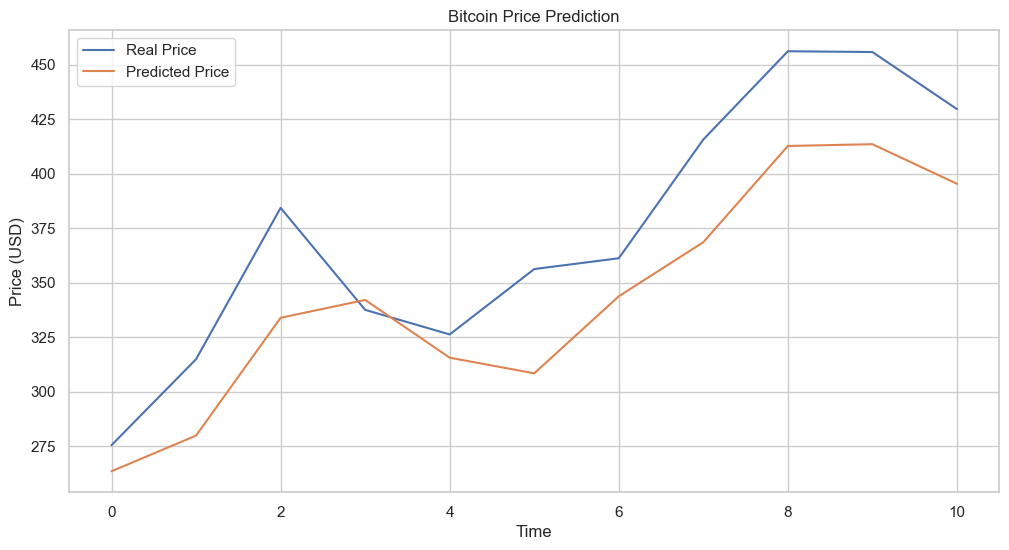

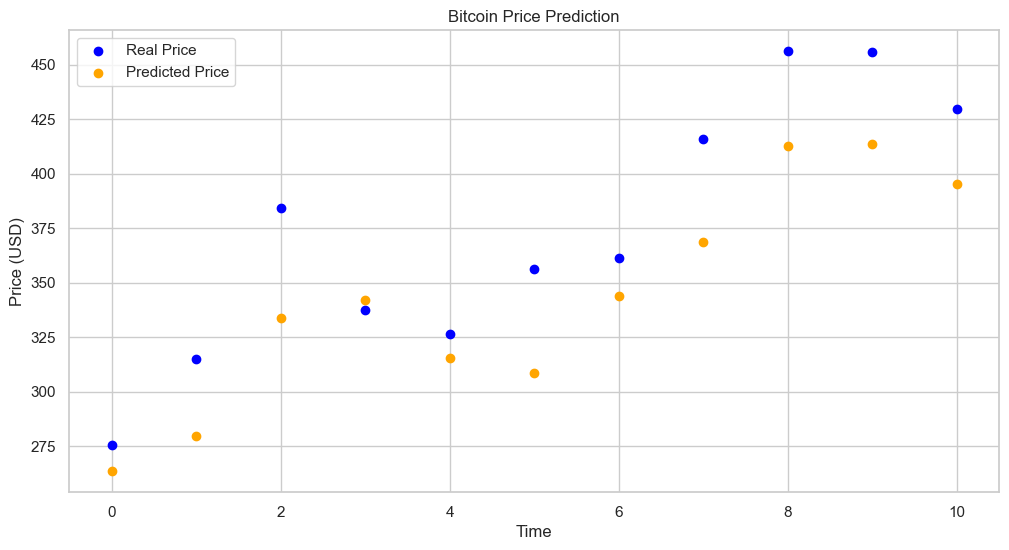

,Real Price,Predicted Price
0,275.41,263.44
1,314.88,279.81
2,384.34,333.88
3,337.52,342.09
4,326.23,315.56
5,356.26,308.39
6,361.21,343.76
7,415.73,368.58
8,456.24,412.76
9,455.88,413.56


Mean Squared Error (MSE): 1248.1234473415195
Root Mean Squared Error (RMSE): 35.328790629478384
Mean Absolute Error (MAE): 31.38958060313878
R² Score: 0.6156485965533458
Testing with: ['HashRate', 'total_received_satoshi'] 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0689 - val_loss: 0.0295
Epoch 2/100
1/1 [==============================] - 0s 34ms/step - loss: 0.0505 - val_loss: 0.0180
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0349 - val_loss: 0.0088
Epoch 4/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0215 - val_loss: 0.0025
Epoch 5/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0107 - val_loss: 4.4495e-04
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0037 - val_loss: 0.0044
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0024 - val_loss: 0.0136
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0072 - val_lo

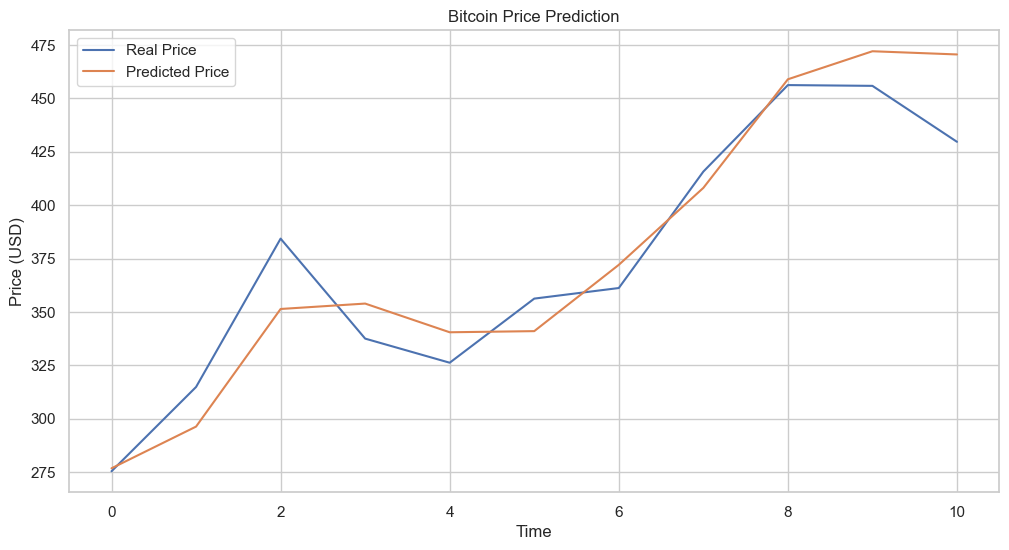

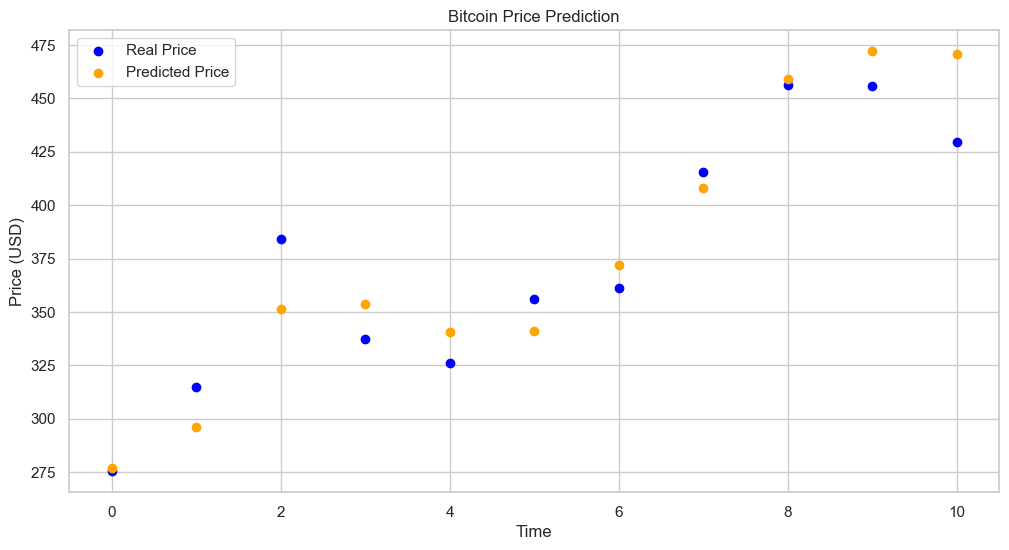

,Real Price,Predicted Price
0,275.41,276.80
1,314.88,296.33
2,384.34,351.40
3,337.52,353.93
4,326.23,340.49
5,356.26,341.03
6,361.21,372.07
7,415.73,408.10
8,456.24,458.96
9,455.88,472.08


Mean Squared Error (MSE): 386.84230257386895
Root Mean Squared Error (RMSE): 19.66830705917184
Mean Absolute Error (MAE): 16.099558539100283
R² Score: 0.8808744581928216
Testing with: ['HashRate', 'nb_transactions'] 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0697 - val_loss: 0.0278
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0479 - val_loss: 0.0136
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0297 - val_loss: 0.0040
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0151 - val_loss: 4.7126e-04
Epoch 5/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0053 - val_loss: 0.0052
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0022 - val_loss: 0.0179
Epoch 7/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0067 - val_loss: 0.0279
Epoch 8/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0120 - val_loss: 0.0

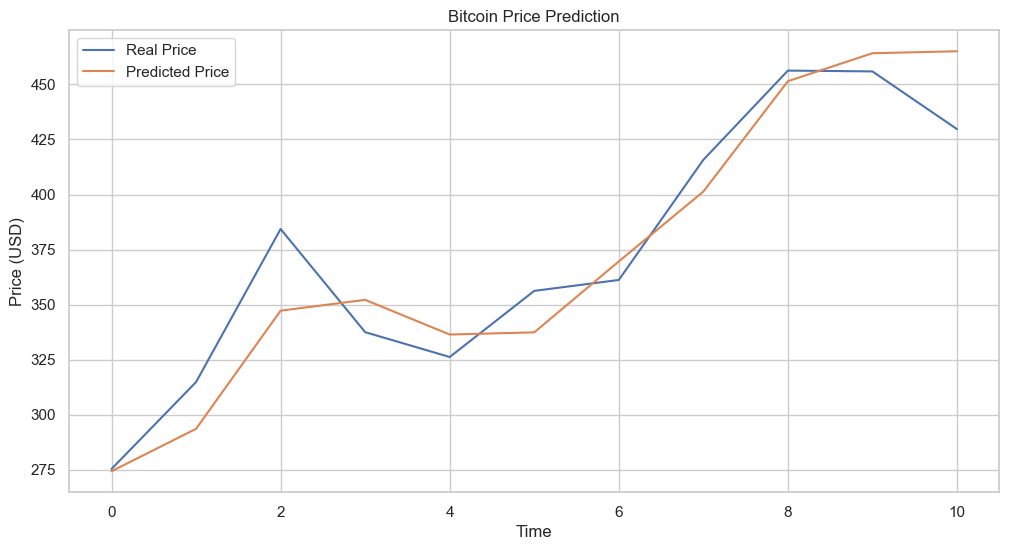

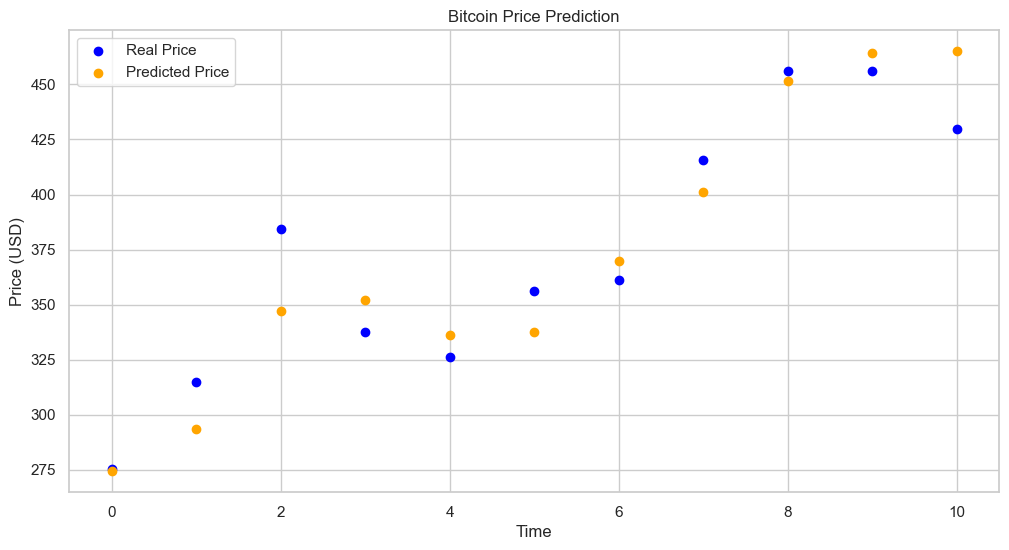

,Real Price,Predicted Price
0,275.41,274.38
1,314.88,293.64
2,384.34,347.28
3,337.52,352.18
4,326.23,336.44
5,356.26,337.43
6,361.21,369.62
7,415.73,401.32
8,456.24,451.44
9,455.88,464.13


Mean Squared Error (MSE): 374.3653089774552
Root Mean Squared Error (RMSE): 19.348522139363904
Mean Absolute Error (MAE): 15.839711217595736
R² Score: 0.8847166662771189
Testing with: ['total_received_satoshi', 'nb_transactions'] 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0797 - val_loss: 0.0365
Epoch 2/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0570 - val_loss: 0.0217
Epoch 3/100
1/1 [==============================] - 0s 55ms/step - loss: 0.0380 - val_loss: 0.0103
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0222 - val_loss: 0.0028
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0102 - val_loss: 6.0726e-04
Epoch 6/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0032 - val_loss: 0.0054
Epoch 7/100
1/1 [==============================] - 0s 47ms/step - loss: 0.0034 - val_loss: 0.0148
Epoch 8/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0093 -

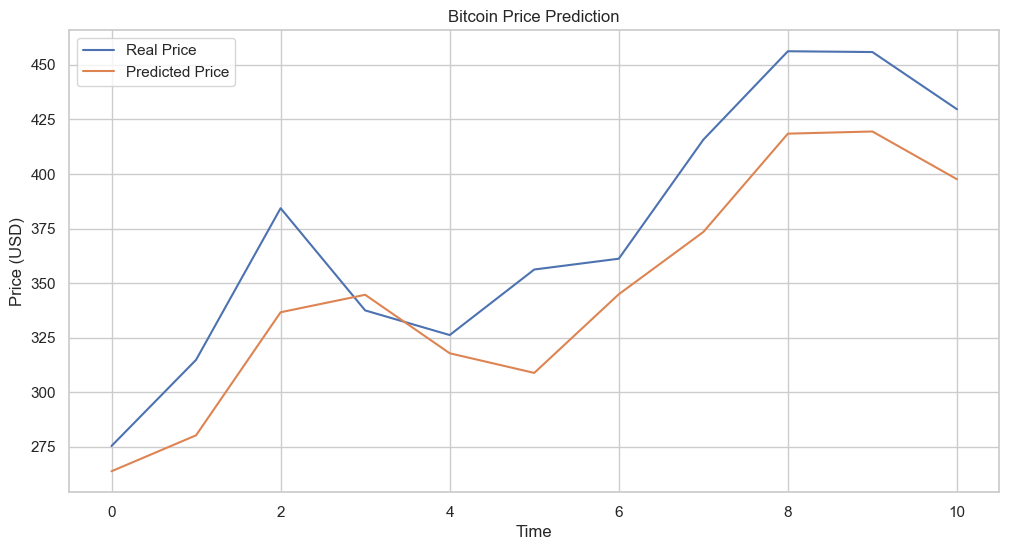

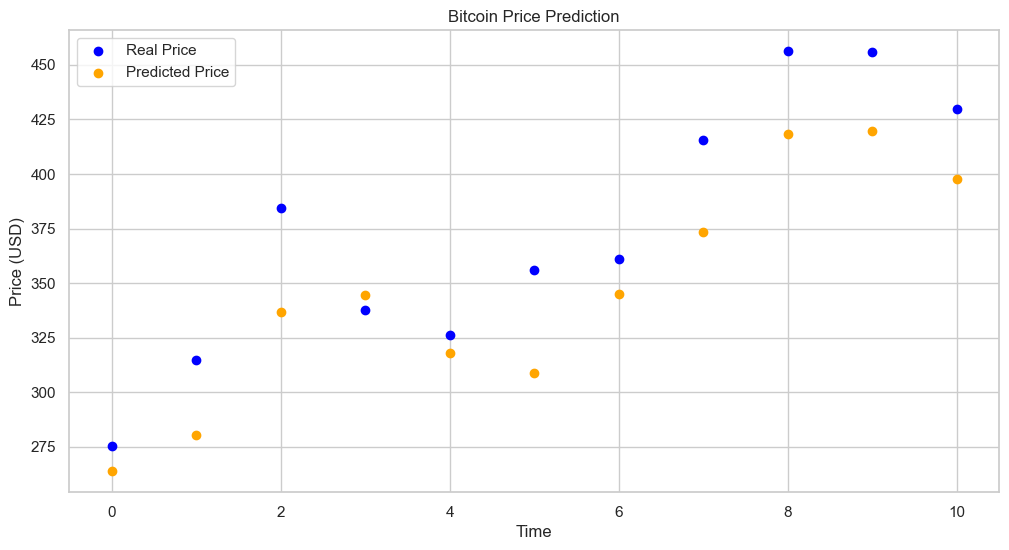

,Real Price,Predicted Price
0,275.41,263.84
1,314.88,280.30
2,384.34,336.67
3,337.52,344.68
4,326.23,317.89
5,356.26,308.89
6,361.21,344.93
7,415.73,373.45
8,456.24,418.49
9,455.88,419.48


Mean Squared Error (MSE): 1072.4525773249218
Root Mean Squared Error (RMSE): 32.74832174821974
Mean Absolute Error (MAE): 29.22380933286363
R² Score: 0.6697452851296153
Testing with: ['HashRate', 'total_received_satoshi', 'nb_transactions'] 

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0805 - val_loss: 0.0309
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0548 - val_loss: 0.0145
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0349 - val_loss: 0.0044
Epoch 4/100
1/1 [==============================] - 0s 44ms/step - loss: 0.0196 - val_loss: 7.0560e-04
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0088 - val_loss: 0.0046
Epoch 6/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0033 - val_loss: 0.0166
Epoch 7/100
1/1 [==============================] - 0s 42ms/step - loss: 0.0040 - val_loss: 0.0314
Epoch 8/100
1/1 [==============================] - 0s 42ms/step - los

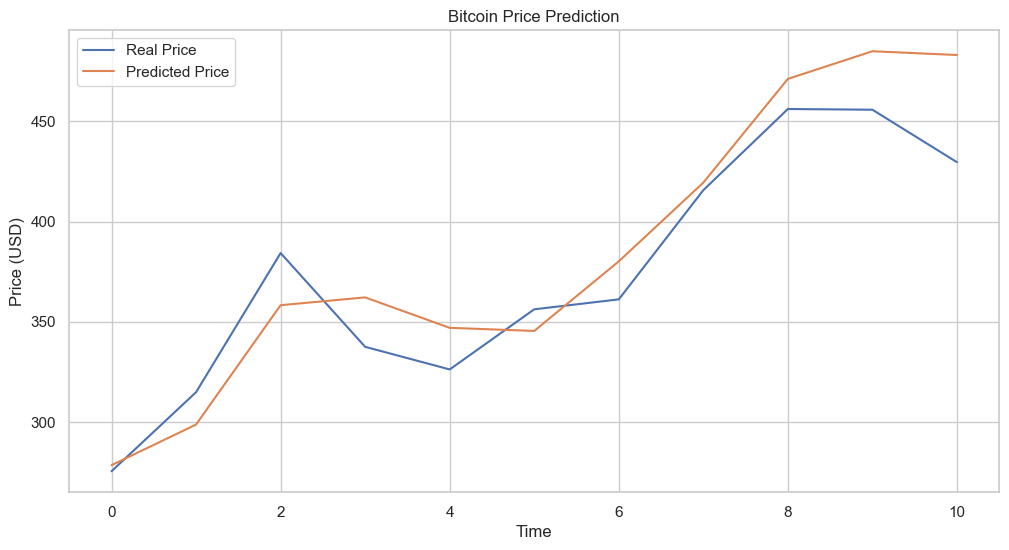

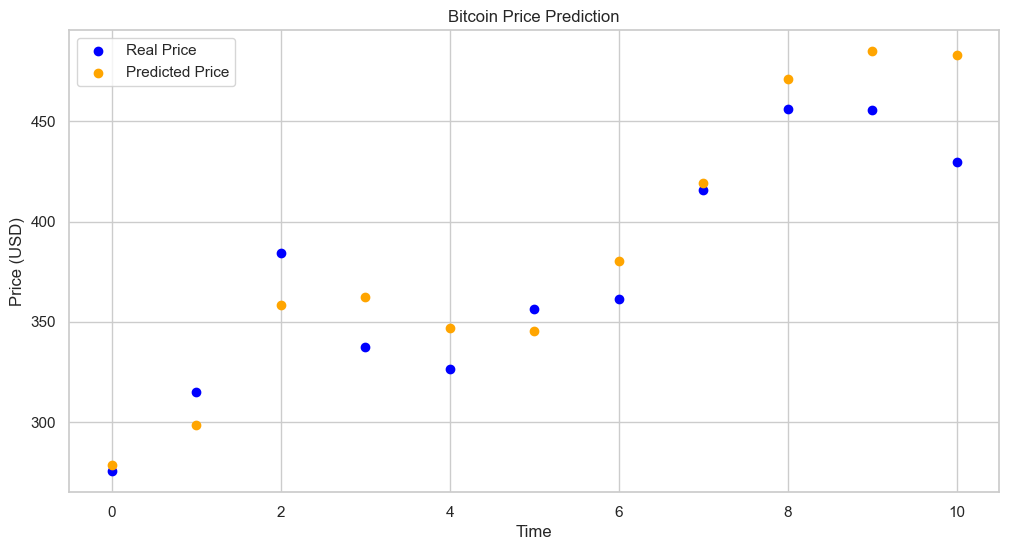

,Real Price,Predicted Price
0,275.41,278.44
1,314.88,298.74
2,384.34,358.30
3,337.52,362.20
4,326.23,347.00
5,356.26,345.45
6,361.21,380.19
7,415.73,419.49
8,456.24,471.28
9,455.88,485.07


Mean Squared Error (MSE): 583.6955784307409
Root Mean Squared Error (RMSE): 24.159792599083726
Mean Absolute Error (MAE): 20.175501310809178
R² Score: 0.8202547871099521


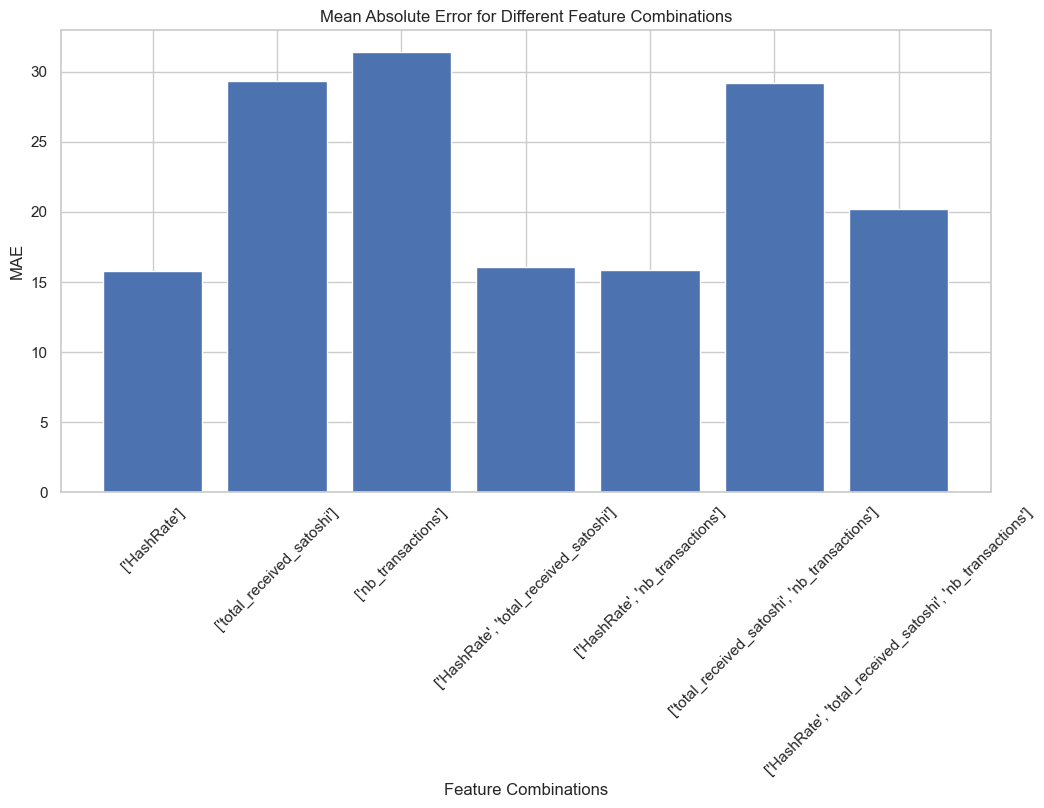

In [27]:
# features = ['HashRate', 'total_received_satoshi', 'nb_transactions', 'week', 'month', 'volume_without_self', 'total_sent_satoshi']
features = ['HashRate', 'total_received_satoshi', 'nb_transactions']
all_combinations = list(combinations(features, r) for r in range(1, len(features) + 1))

# Dictionnaire pour stocker les MAE de chaque combinaison de features
mae_dict = {}

for combo in all_combinations:
    for subcombo in combo:
        print("Testing with:", list(subcombo), "\n")
        data = read_data('../data/timeseries/2015/merged.csv', features=['PriceUSD'] + list(subcombo))
        data_scaled, scaler = scale_data(data)
        X, y = create_sequences_features(data_scaled, seq_length)
        trainX, testX, trainY, testY = train_test_split(X, y)
        model = build_model(trainX.shape[1:])
        predictions = train_and_test_model(model, trainX, testX, trainY)
        predicted_prices, real_prices = inverse_transform_predictions(predictions, testY, scaler, nb_features=trainX.shape[2])
        mse, rmse, mae, r2 = show_results(predicted_prices, real_prices)
        mae_dict[str(list(subcombo))] = mae

# Créer un graphique à barres pour les MAE
plt.figure(figsize=(12, 6))
plt.bar(range(len(mae_dict)), list(mae_dict.values()), align='center')
plt.xticks(range(len(mae_dict)), list(mae_dict.keys()), rotation=45)
plt.title('Mean Absolute Error for Different Feature Combinations')
plt.xlabel('Feature Combinations')
plt.ylabel('MAE')
plt.show()

In [ ]:
predictions = train_and_test_model(model, trainX, testX, trainY)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.0741 - val_loss: 0.0141
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0452 - val_loss: 6.0798e-04
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0242 - val_loss: 0.0087
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0107 - val_loss: 0.0418
Epoch 5/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0064 - val_loss: 0.0904
Epoch 6/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0110 - val_loss: 0.1160
Epoch 7/100
1/1 [==============================] - 0s 41ms/step - loss: 0.0159 - val_loss: 0.1081
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0151 - val_loss: 0.0828
Epoch 9/100
1/1 [==============================] - 0s 36ms/step - loss: 0.0109 - val_loss: 0.0553
Epoch 10/100
1/1 [==============================] - 0s 40ms/step - loss: 0.0069 - val_loss: 0.0332
Epoch 11/100
1/1 

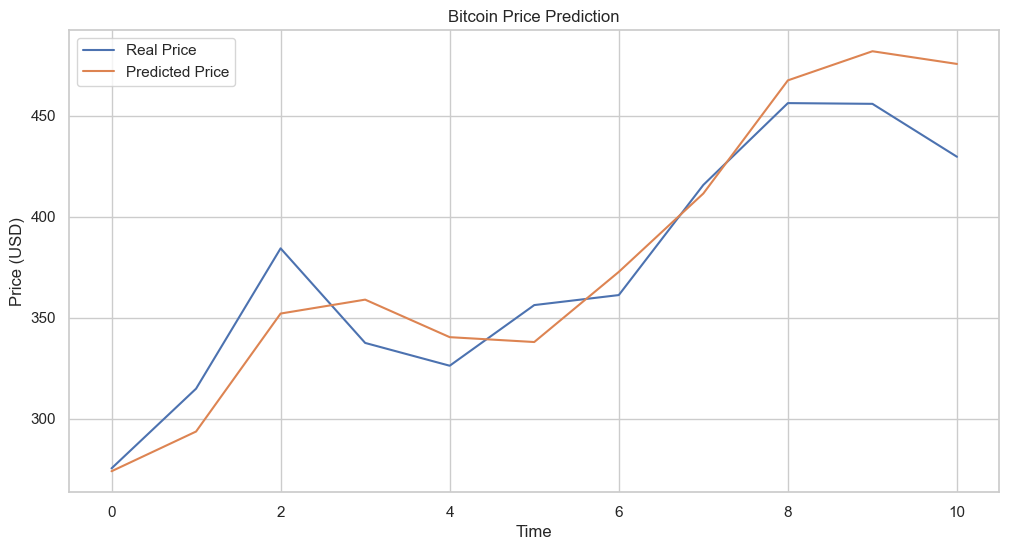

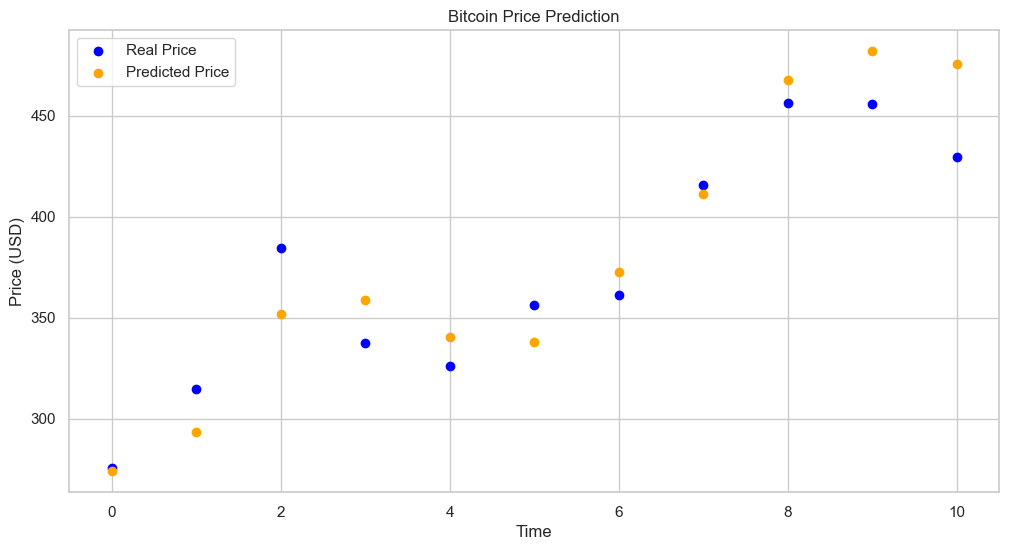

,Real Price,Predicted Price
0,275.41,274.00
1,314.88,293.66
2,384.34,352.06
3,337.52,358.95
4,326.23,340.38
5,356.26,337.97
6,361.21,372.69
7,415.73,411.49
8,456.24,467.50
9,455.88,481.91


Mean Squared Error (MSE): 504.880372016286
Root Mean Squared Error (RMSE): 22.469543208892475
Mean Absolute Error (MAE): 18.885098270665306
R² Score: 0.8445254113521747


In [ ]:
predicted_prices, real_prices = inverse_transform_predictions(predictions, testY, scaler, nb_features=trainX.shape[2])
show_results(predicted_prices, real_prices)

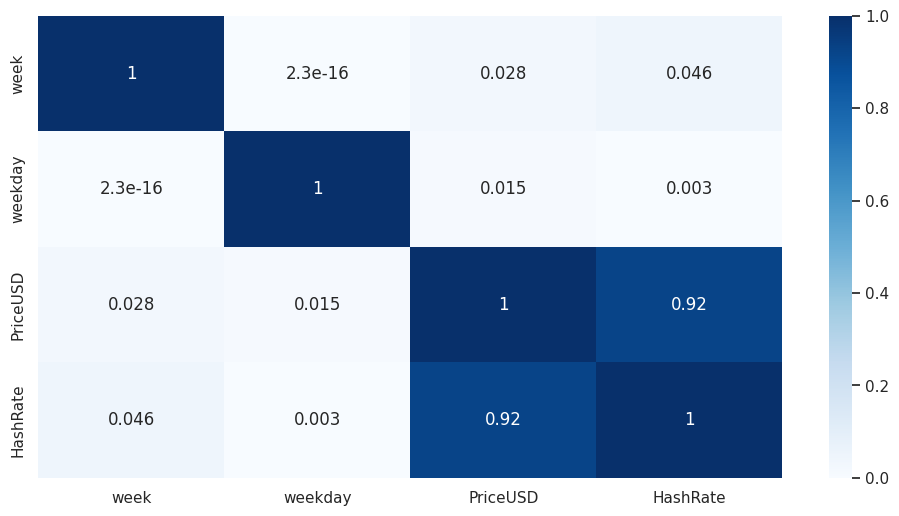

In [ ]:
df = pd.read_csv('../data/timeseries/task1/external.csv')
global_df = pd.read_csv('../data/timeseries/task1/global.csv')

corr = df.corr()

# plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(corr, annot=True, cmap='Blues')
plt.show()